In [1]:
from music21 import *
import glob
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt

import keras
from keras.utils import *

Using TensorFlow backend.


In [2]:
note_to_int = ['rest', 'C4', 'C#4', 'D-4', 'D4', 'D#4', 'E-4', 'E4', 'F4', 'F#4', 'G-4', 'G4', 'G#4', 'A-4', 'A4', 'A#4', 'B-4', 'B4', 'C5', 'C#5', 'D-5', 'D5', 'D#5', 'E-5', 'E5', 'F5', 'F#5', 'G-5', 'G5', 'G#5', 'A-5', 'A5', 'A#5', 'B-5', 'B5', 'C6', 'C#6', 'D-6', 'D6', 'D#6', 'E-6', 'E6', 'F6', 'F#6', 'G-6', 'G6', 'G#6', 'A-6', 'A6', 'A#6', 'B-6', 'B6', 'C7', 'C#7', 'D-7', 'D7', 'D#7', 'E-7', 'E7', 'F7', 'F#7', 'G-7', 'G7', 'G#7', 'A-7', 'A7', 'A#7', 'B-7', 'B7', 'C8', 'C#8', 'D-8', 'D8', 'D#8', 'E-8', 'E8', 'F8', 'F#8', 'G-8', 'G8', 'G#8', 'A-8', 'A8', 'A#8', 'B-8', 'B8', 'C9']
duration_list = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0]    

In [3]:
def readMidi(score, filename):
    # Loop through all the parts in the score
    # each part is the score for an instrument
    
    print(f"Parsing {filename}")
    
    try:
        key = score.analyze('key')
        if key.mode == 'minor':
            print("minor")
            return
        score = transpose(score)
    except:
        return
    
    try:
        data = []
        for part in score.parts:
            
            # Check for nested parts
            if (hasattr(part, "parts")):
                readMidi(part)
            else:
                data += readPart(part)


        data = [x for x in data if x != []]
        
        
        print(data)
    except:
        pass
    return
            
            
def readPart(part):    
    # holds the measures as a list
    score = []
    
    # parse the file
    if len(part.voices) > 0:
        for voice in part.voices:
            score.append(readVoices(voice))
    else:
        # keeps track of which measure we are on
        measureCounter = 0
        data = []
        print("PART----------------")
        part.measures.show()
        for measure in part.measures(0, None):
            # go though all measures and see if the key, clef or timesignature has changed
            # exit if it has
            if measureCounter == 0:
                # check if the score/measure uses the correct time signature
                if not checkTimeSignature(measure, '4/4'):
                    break
            if measureCounter > 0 and (measure.__dict__["keyIsNew"] or measure.__dict__["clefIsNew"] or measure.__dict__["timeSignatureIsNew"]):
                break
            
            data += readMeasure(measure)
            measureCounter+=1
    return score


def readVoices(voice):
    measureCounter = 0
    data = []
    
    print("VOICE------------------")
    voice.measures.show()
    for measure in voice.measures(0, None):
        # go though all measures and see if the key, clef or timesignature has changed
        # exit if it has
        if measureCounter == 0:
            # check if the score/measure uses the correct time signature
            if not checkTimeSignature(measure, '4/4'):
                break
        elif measureCounter > 0 and (measure.__dict__["keyIsNew"] or measure.__dict__["clefIsNew"] or measure.__dict__["timeSignatureIsNew"]):
            break

        
        measureData = readMeasure(measure)
        if measureData == []:
            break
        data += measureData
        measureCounter+=1
    return data


def readMeasure(measure):
    # loop over all of the measures in the score

    # check if the measure contains a note and doesn't contain chords
    if metRequirements(measure):
        
        data = measureToList(measure)
        return data
    else:
        return []

In [4]:
# -------------MAIN FUNCTION--------------------
def midiToNetworkInput(midi):
    notes = getNotes(midi)
    return createNetworkInput(notes)

def partToNetworkInput(part):
    notes = getNotesFromPart(part)
    pprint(notes)
    return createNetworkInput(notes)

def measureToList(measure):
    notes = getNotes(measure)
    return createNetworkInput(notes)
    
    

# -------------HELPER FUNCTIONS-----------------
def noteToFloat(note):
    note_to_float = {'rest': 0.0, 'C0': 0.004524886877828055, 'C#0': 0.00904977375565611, 'D-0': 0.013574660633484163, 'D0': 0.01809954751131222, 'D#0': 0.02262443438914027, 'E-0': 0.027149321266968326, 'E0': 0.03167420814479638, 'F0': 0.03619909502262444, 'F#0': 0.04072398190045249, 'G-0': 0.04524886877828054, 'G0': 0.049773755656108594, 'G#0': 0.05429864253393665, 'A-0': 0.058823529411764705, 'A0': 0.06334841628959276, 'A#0': 0.06787330316742081, 'B-0': 0.07239819004524888, 'B0': 0.07692307692307693, 'C1': 0.08144796380090498, 'C#1': 0.08597285067873303, 'D-1': 0.09049773755656108, 'D1': 0.09502262443438914, 'D#1': 0.09954751131221719, 'E-1': 0.10407239819004525, 'E1': 0.1085972850678733, 'F1': 0.11312217194570136, 'F#1': 0.11764705882352941, 'G-1': 0.12217194570135746, 'G1': 0.12669683257918551, 'G#1': 0.13122171945701358, 'A-1': 0.13574660633484162, 'A1': 0.14027149321266968, 'A#1': 0.14479638009049775, 'B-1': 0.1493212669683258, 'B1': 0.15384615384615385, 'C2': 0.1583710407239819, 'C#2': 0.16289592760180996, 'D-2': 0.167420814479638, 'D2': 0.17194570135746606, 'D#2': 0.17647058823529413, 'E-2': 0.18099547511312217, 'E2': 0.18552036199095023, 'F2': 0.19004524886877827, 'F#2': 0.19457013574660634, 'G-2': 0.19909502262443438, 'G2': 0.20361990950226244, 'G#2': 0.2081447963800905, 'A-2': 0.21266968325791855, 'A2': 0.2171945701357466, 'A#2': 0.22171945701357465, 'B-2': 0.22624434389140272, 'B2': 0.23076923076923078, 'C3': 0.23529411764705882, 'C#3': 0.2398190045248869, 'D-3': 0.24434389140271492, 'D3': 0.248868778280543, 'D#3': 0.25339366515837103, 'E-3': 0.2579185520361991, 'E3': 0.26244343891402716, 'F3': 0.2669683257918552, 'F#3': 0.27149321266968324, 'G-3': 0.27601809954751133, 'G3': 0.28054298642533937, 'G#3': 0.2850678733031674, 'A-3': 0.2895927601809955, 'A3': 0.29411764705882354, 'A#3': 0.2986425339366516, 'B-3': 0.3031674208144796, 'B3': 0.3076923076923077, 'C4': 0.31221719457013575, 'C#4': 0.3167420814479638, 'D-4': 0.3212669683257919, 'D4': 0.3257918552036199, 'D#4': 0.33031674208144796, 'E-4': 0.334841628959276, 'E4': 0.3393665158371041, 'F4': 0.3438914027149321, 'F#4': 0.34841628959276016, 'G-4': 0.35294117647058826, 'G4': 0.3574660633484163, 'G#4': 0.36199095022624433, 'A-4': 0.3665158371040724, 'A4': 0.37104072398190047, 'A#4': 0.3755656108597285, 'B-4': 0.38009049773755654, 'B4': 0.38461538461538464, 'C5': 0.3891402714932127, 'C#5': 0.3936651583710407, 'D-5': 0.39819004524886875, 'D5': 0.40271493212669685, 'D#5': 0.4072398190045249, 'E-5': 0.4117647058823529, 'E5': 0.416289592760181, 'F5': 0.42081447963800905, 'F#5': 0.4253393665158371, 'G-5': 0.4298642533936652, 'G5': 0.4343891402714932, 'G#5': 0.43891402714932126, 'A-5': 0.4434389140271493, 'A5': 0.4479638009049774, 'A#5': 0.45248868778280543, 'B-5': 0.45701357466063347, 'B5': 0.46153846153846156, 'C6': 0.4660633484162896, 'C#6': 0.47058823529411764, 'D-6': 0.4751131221719457, 'D6': 0.4796380090497738, 'D#6': 0.4841628959276018, 'E-6': 0.48868778280542985, 'E6': 0.49321266968325794, 'F6': 0.497737556561086, 'F#6': 0.502262443438914, 'G-6': 0.5067873303167421, 'G6': 0.5113122171945701, 'G#6': 0.5158371040723982, 'A-6': 0.5203619909502263, 'A6': 0.5248868778280543, 'A#6': 0.5294117647058824, 'B-6': 0.5339366515837104, 'B6': 0.5384615384615384, 'C7': 0.5429864253393665, 'C#7': 0.5475113122171946, 'D-7': 0.5520361990950227, 'D7': 0.5565610859728507, 'D#7': 0.5610859728506787, 'E-7': 0.5656108597285068, 'E7': 0.5701357466063348, 'F7': 0.5746606334841629, 'F#7': 0.579185520361991, 'G-7': 0.583710407239819, 'G7': 0.5882352941176471, 'G#7': 0.5927601809954751, 'A-7': 0.5972850678733032, 'A7': 0.6018099547511312, 'A#7': 0.6063348416289592, 'B-7': 0.6108597285067874, 'B7': 0.6153846153846154, 'C8': 0.6199095022624435, 'C#8': 0.6244343891402715, 'D-8': 0.6289592760180995, 'D8': 0.6334841628959276, 'D#8': 0.6380090497737556, 'E-8': 0.6425339366515838, 'E8': 0.6470588235294118, 'F8': 0.6515837104072398, 'F#8': 0.6561085972850679, 'G-8': 0.6606334841628959, 'G8': 0.665158371040724, 'G#8': 0.669683257918552, 'A-8': 0.6742081447963801, 'A8': 0.6787330316742082, 'A#8': 0.6832579185520362, 'B-8': 0.6877828054298643, 'B8': 0.6923076923076923, 'C9': 0.6968325791855203, 'C#9': 0.7013574660633484, 'D-9': 0.7058823529411765, 'D9': 0.7104072398190046, 'D#9': 0.7149321266968326, 'E-9': 0.7194570135746606, 'E9': 0.7239819004524887, 'F9': 0.7285067873303167, 'F#9': 0.7330316742081447, 'G-9': 0.7375565610859729, 'G9': 0.7420814479638009, 'G#9': 0.746606334841629, 'A-9': 0.751131221719457, 'A9': 0.755656108597285, 'A#9': 0.7601809954751131, 'B-9': 0.7647058823529411, 'B9': 0.7692307692307693, 'C10': 0.7737556561085973, 'C#10': 0.7782805429864253, 'D-10': 0.7828054298642534, 'D10': 0.7873303167420814, 'D#10': 0.7918552036199095, 'E-10': 0.7963800904977375, 'E10': 0.8009049773755657, 'F10': 0.8054298642533937, 'F#10': 0.8099547511312217, 'G-10': 0.8144796380090498, 'G10': 0.8190045248868778, 'G#10': 0.8235294117647058, 'A-10': 0.8280542986425339, 'A10': 0.832579185520362, 'A#10': 0.8371040723981901, 'B-10': 0.8416289592760181, 'B10': 0.8461538461538461, 'C11': 0.8506787330316742, 'C#11': 0.8552036199095022, 'D-11': 0.8597285067873304, 'D11': 0.8642533936651584, 'D#11': 0.8687782805429864, 'E-11': 0.8733031674208145, 'E11': 0.8778280542986425, 'F11': 0.8823529411764706, 'F#11': 0.8868778280542986, 'G-11': 0.8914027149321267, 'G11': 0.8959276018099548, 'G#11': 0.9004524886877828, 'A-11': 0.9049773755656109, 'A11': 0.9095022624434389, 'A#11': 0.9140271493212669, 'B-11': 0.918552036199095, 'B11': 0.9230769230769231, 'C12': 0.9276018099547512, 'C#12': 0.9321266968325792, 'D-12': 0.9366515837104072, 'D12': 0.9411764705882353, 'D#12': 0.9457013574660633, 'E-12': 0.9502262443438914, 'E12': 0.9547511312217195, 'F12': 0.9592760180995475, 'F#12': 0.9638009049773756, 'G-12': 0.9683257918552036, 'G12': 0.9728506787330317, 'G#12': 0.9773755656108597, 'A-12': 0.9819004524886877, 'A12': 0.9864253393665159, 'A#12': 0.9909502262443439, 'B-12': 0.995475113122172, 'B12': 1.0}
    return note_to_float[note]

def noteToInt(note):
    note_to_int = ['rest', 'C6', 'C#6', 'D-6', 'D6', 'D#6', 'E-6', 'E6', 'F6', 'F#6', 'G-6', 'G6', 'G#6', 'A-6', 'A6', 'A#6', 'B-6', 'B6', 'C7', 'C#7', 'D-7', 'D7', 'D#7', 'E-7', 'E7', 'F7', 'F#7', 'G-7', 'G7', 'G#7', 'A-7', 'A7', 'A#7', 'B-7', 'B7', 'C8', 'C#8', 'D-8', 'D8', 'D#8', 'E-8', 'E8', 'F8', 'F#8', 'G-8', 'G8', 'G#8', 'A-8', 'A8', 'A#8', 'B-8', 'B8', 'C9']
    return note_to_int.index(note)

def getDuration(note):
    duration = note.duration.quarterLength
    if isinstance(duration, Fraction):
        return duration.numerator/duration.denominator # used to be round(duration.numerator/duration.denominator, 3)
    else:
        return duration

def getDurationAsInt(note):
    duration_list = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0]
    if note.duration.quarterLengthNoTuplets not in duration_list:
        return None
    return duration_list.index(note.duration.quarterLengthNoTuplets)

def createNetworkInput(notes):
    network_input = []
    for element in notes:
        durationInt = getDurationAsInt(element)
        if durationInt == None:
            break
        if element.isRest:
            network_input.append([noteToInt(element.name), durationInt])
        elif element.isNote:
            network_input.append([noteToInt(element.nameWithOctave), durationInt])
    return network_input

def getNotes(midi):
    part = midi.notes
    midi.show()
#     part = midi.__dict__["_elements"][0].__dict__["_elements"]
    return [element for element in part if isinstance(element, note.GeneralNote)]

def getNotesFromPart(part):
    partElements = midi.__dict__["_elements"]
    return [element for element in partElements if isinstance(element, note.GeneralNote)]

def normalise(value):
    return (value-0)/(221-0)

In [23]:
# -----------------MAIN FUNCTION-----------------------
def numpyToMidi(location):
    for file in glob.glob(f'{location}*.npy'):
        arr = np.load(file)
        filename = file[file.rfind("/")+1:-4]
        numpyArrToMidi(arr, filename)

# -----------------HELPER FUNCTION---------------------
def numpyArrToMidi(npArr, filename):
    output = stream.Score(id='mainScore')
    filePart = stream.Part(id='part0')
    for note in npArr:
        noteString = arrToNoteName(note[0])
        duration = getDurationFromArray(note[1])
        noteObject = getNote(noteString, duration)
        filePart.append(noteObject)
    output.insert(0, filePart)
    filename = filename + ".mid"
    output.write(fmt="midi", fp=f"{filename}")
    print(f" ✔️ {filename} was written")
    output.show()
    
def show(npArr):
    output = stream.Score(id='mainScore')
    filePart = stream.Part(id='part0')
    for note in npArr:
        noteString = arrToNoteName(note[0])
        duration = getDurationFromArray(note[1])
        noteObject = getNote(noteString, duration)
        filePart.append(noteObject)
    output.insert(0, filePart)
    output.show()

def getNote(noteString, duration):
    if noteString != 'rest':
        noteObject = note.Note(noteString)
        noteObject.duration.quarterLength = duration
        return noteObject
    else:
        return note.Rest()

def floatToNoteName(value):
    note_to_float = {'rest': 0.0, 'C0': 0.004524886877828055, 'C#0': 0.00904977375565611, 'D-0': 0.013574660633484163, 'D0': 0.01809954751131222, 'D#0': 0.02262443438914027, 'E-0': 0.027149321266968326, 'E0': 0.03167420814479638, 'F0': 0.03619909502262444, 'F#0': 0.04072398190045249, 'G-0': 0.04524886877828054, 'G0': 0.049773755656108594, 'G#0': 0.05429864253393665, 'A-0': 0.058823529411764705, 'A0': 0.06334841628959276, 'A#0': 0.06787330316742081, 'B-0': 0.07239819004524888, 'B0': 0.07692307692307693, 'C1': 0.08144796380090498, 'C#1': 0.08597285067873303, 'D-1': 0.09049773755656108, 'D1': 0.09502262443438914, 'D#1': 0.09954751131221719, 'E-1': 0.10407239819004525, 'E1': 0.1085972850678733, 'F1': 0.11312217194570136, 'F#1': 0.11764705882352941, 'G-1': 0.12217194570135746, 'G1': 0.12669683257918551, 'G#1': 0.13122171945701358, 'A-1': 0.13574660633484162, 'A1': 0.14027149321266968, 'A#1': 0.14479638009049775, 'B-1': 0.1493212669683258, 'B1': 0.15384615384615385, 'C2': 0.1583710407239819, 'C#2': 0.16289592760180996, 'D-2': 0.167420814479638, 'D2': 0.17194570135746606, 'D#2': 0.17647058823529413, 'E-2': 0.18099547511312217, 'E2': 0.18552036199095023, 'F2': 0.19004524886877827, 'F#2': 0.19457013574660634, 'G-2': 0.19909502262443438, 'G2': 0.20361990950226244, 'G#2': 0.2081447963800905, 'A-2': 0.21266968325791855, 'A2': 0.2171945701357466, 'A#2': 0.22171945701357465, 'B-2': 0.22624434389140272, 'B2': 0.23076923076923078, 'C3': 0.23529411764705882, 'C#3': 0.2398190045248869, 'D-3': 0.24434389140271492, 'D3': 0.248868778280543, 'D#3': 0.25339366515837103, 'E-3': 0.2579185520361991, 'E3': 0.26244343891402716, 'F3': 0.2669683257918552, 'F#3': 0.27149321266968324, 'G-3': 0.27601809954751133, 'G3': 0.28054298642533937, 'G#3': 0.2850678733031674, 'A-3': 0.2895927601809955, 'A3': 0.29411764705882354, 'A#3': 0.2986425339366516, 'B-3': 0.3031674208144796, 'B3': 0.3076923076923077, 'C4': 0.31221719457013575, 'C#4': 0.3167420814479638, 'D-4': 0.3212669683257919, 'D4': 0.3257918552036199, 'D#4': 0.33031674208144796, 'E-4': 0.334841628959276, 'E4': 0.3393665158371041, 'F4': 0.3438914027149321, 'F#4': 0.34841628959276016, 'G-4': 0.35294117647058826, 'G4': 0.3574660633484163, 'G#4': 0.36199095022624433, 'A-4': 0.3665158371040724, 'A4': 0.37104072398190047, 'A#4': 0.3755656108597285, 'B-4': 0.38009049773755654, 'B4': 0.38461538461538464, 'C5': 0.3891402714932127, 'C#5': 0.3936651583710407, 'D-5': 0.39819004524886875, 'D5': 0.40271493212669685, 'D#5': 0.4072398190045249, 'E-5': 0.4117647058823529, 'E5': 0.416289592760181, 'F5': 0.42081447963800905, 'F#5': 0.4253393665158371, 'G-5': 0.4298642533936652, 'G5': 0.4343891402714932, 'G#5': 0.43891402714932126, 'A-5': 0.4434389140271493, 'A5': 0.4479638009049774, 'A#5': 0.45248868778280543, 'B-5': 0.45701357466063347, 'B5': 0.46153846153846156, 'C6': 0.4660633484162896, 'C#6': 0.47058823529411764, 'D-6': 0.4751131221719457, 'D6': 0.4796380090497738, 'D#6': 0.4841628959276018, 'E-6': 0.48868778280542985, 'E6': 0.49321266968325794, 'F6': 0.497737556561086, 'F#6': 0.502262443438914, 'G-6': 0.5067873303167421, 'G6': 0.5113122171945701, 'G#6': 0.5158371040723982, 'A-6': 0.5203619909502263, 'A6': 0.5248868778280543, 'A#6': 0.5294117647058824, 'B-6': 0.5339366515837104, 'B6': 0.5384615384615384, 'C7': 0.5429864253393665, 'C#7': 0.5475113122171946, 'D-7': 0.5520361990950227, 'D7': 0.5565610859728507, 'D#7': 0.5610859728506787, 'E-7': 0.5656108597285068, 'E7': 0.5701357466063348, 'F7': 0.5746606334841629, 'F#7': 0.579185520361991, 'G-7': 0.583710407239819, 'G7': 0.5882352941176471, 'G#7': 0.5927601809954751, 'A-7': 0.5972850678733032, 'A7': 0.6018099547511312, 'A#7': 0.6063348416289592, 'B-7': 0.6108597285067874, 'B7': 0.6153846153846154, 'C8': 0.6199095022624435, 'C#8': 0.6244343891402715, 'D-8': 0.6289592760180995, 'D8': 0.6334841628959276, 'D#8': 0.6380090497737556, 'E-8': 0.6425339366515838, 'E8': 0.6470588235294118, 'F8': 0.6515837104072398, 'F#8': 0.6561085972850679, 'G-8': 0.6606334841628959, 'G8': 0.665158371040724, 'G#8': 0.669683257918552, 'A-8': 0.6742081447963801, 'A8': 0.6787330316742082, 'A#8': 0.6832579185520362, 'B-8': 0.6877828054298643, 'B8': 0.6923076923076923, 'C9': 0.6968325791855203, 'C#9': 0.7013574660633484, 'D-9': 0.7058823529411765, 'D9': 0.7104072398190046, 'D#9': 0.7149321266968326, 'E-9': 0.7194570135746606, 'E9': 0.7239819004524887, 'F9': 0.7285067873303167, 'F#9': 0.7330316742081447, 'G-9': 0.7375565610859729, 'G9': 0.7420814479638009, 'G#9': 0.746606334841629, 'A-9': 0.751131221719457, 'A9': 0.755656108597285, 'A#9': 0.7601809954751131, 'B-9': 0.7647058823529411, 'B9': 0.7692307692307693, 'C10': 0.7737556561085973, 'C#10': 0.7782805429864253, 'D-10': 0.7828054298642534, 'D10': 0.7873303167420814, 'D#10': 0.7918552036199095, 'E-10': 0.7963800904977375, 'E10': 0.8009049773755657, 'F10': 0.8054298642533937, 'F#10': 0.8099547511312217, 'G-10': 0.8144796380090498, 'G10': 0.8190045248868778, 'G#10': 0.8235294117647058, 'A-10': 0.8280542986425339, 'A10': 0.832579185520362, 'A#10': 0.8371040723981901, 'B-10': 0.8416289592760181, 'B10': 0.8461538461538461, 'C11': 0.8506787330316742, 'C#11': 0.8552036199095022, 'D-11': 0.8597285067873304, 'D11': 0.8642533936651584, 'D#11': 0.8687782805429864, 'E-11': 0.8733031674208145, 'E11': 0.8778280542986425, 'F11': 0.8823529411764706, 'F#11': 0.8868778280542986, 'G-11': 0.8914027149321267, 'G11': 0.8959276018099548, 'G#11': 0.9004524886877828, 'A-11': 0.9049773755656109, 'A11': 0.9095022624434389, 'A#11': 0.9140271493212669, 'B-11': 0.918552036199095, 'B11': 0.9230769230769231, 'C12': 0.9276018099547512, 'C#12': 0.9321266968325792, 'D-12': 0.9366515837104072, 'D12': 0.9411764705882353, 'D#12': 0.9457013574660633, 'E-12': 0.9502262443438914, 'E12': 0.9547511312217195, 'F12': 0.9592760180995475, 'F#12': 0.9638009049773756, 'G-12': 0.9683257918552036, 'G12': 0.9728506787330317, 'G#12': 0.9773755656108597, 'A-12': 0.9819004524886877, 'A12': 0.9864253393665159, 'A#12': 0.9909502262443439, 'B-12': 0.995475113122172, 'B12': 1.0}
    return list(note_to_float.keys())[list(note_to_float.values()).index(value)]

def arrToNoteName(value):
    notes = ['rest', 'C4', 'C#4', 'D-4', 'D4', 'D#4', 'E-4', 'E4', 'F4', 'F#4', 'G-4', 'G4', 'G#4', 'A-4', 'A4', 'A#4', 'B-4', 'B4', 'C5', 'C#5', 'D-5', 'D5', 'D#5', 'E-5', 'E5', 'F5', 'F#5', 'G-5', 'G5', 'G#5', 'A-5', 'A5', 'A#5', 'B-5', 'B5', 'C6', 'C#6', 'D-6', 'D6', 'D#6', 'E-6', 'E6', 'F6', 'F#6', 'G-6', 'G6', 'G#6', 'A-6', 'A6', 'A#6', 'B-6', 'B6', 'C7', 'C#7', 'D-7', 'D7', 'D#7', 'E-7', 'E7', 'F7', 'F#7', 'G-7', 'G7', 'G#7', 'A-7', 'A7', 'A#7', 'B-7', 'B7', 'C8', 'C#8', 'D-8', 'D8', 'D#8', 'E-8', 'E8', 'F8', 'F#8', 'G-8', 'G8', 'G#8', 'A-8', 'A8', 'A#8', 'B-8', 'B8', 'C9']
    return notes[value]

def getDurationFromArray(value):
    duration_list = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0]
    return duration_list[value]

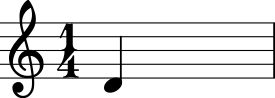

In [6]:
song = note.Note("D4")
song.duration.quarterLength = 1
song.show()

In [7]:
model = keras.models.load_model('../../models/model_full_s2p1.hdf5')

In [9]:
def sample(preds, temperature=1.0, duration=False):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    
    if duration:
        preds = preds[:17]
    
    
    
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    
#     plt.plot(preds)
#     plt.xlabel('Durations')
#     plt.show()
    
    result = np.argmax(probas)
    if result == 0 and duration:
        result = 1
    return result

In [10]:
def generateNote(model, scoreArr):
        
    scoreArr = np.array(scoreArr)

    
    notes = np.array([to_categorical(scoreArr[:,0], 87)])
    lengths = np.array([to_categorical(scoreArr[:,1], 53)])
    prediction = model.predict([notes, lengths])
    pred_note = prediction[0][0]
    pred_length = prediction[1][0]
    
#     plt.title('Probability distribution')
#     plt.rcParams["figure.figsize"] = [15,10]
#     plt.tight_layout()
    
#     plt.subplot(2, 1, 1)
#     plt.bar(np.arange(len(note_to_int)), pred_note)
#     plt.xlabel("Notes")
#     plt.xticks(np.arange(len(note_to_int)), note_to_int, rotation=90)
    

#     plt.subplot(2, 1, 2)
#     plt.bar(np.arange(len(duration_list)), pred_length)
#     plt.xlabel('Durations')
#     plt.xticks(np.arange(len(duration_list)), duration_list, rotation=90)
    
#     plt.show()
    
    pred_note[0] = 0
    pred_length[0] = 0
    
    
#     print("Note prob:\n", pred_note)
#     print(pred_note[4])
#     print("Length prob:\n",pred_length)
    
    next_note_index = sample(pred_note, 1.3)
    next_length_index = sample(pred_length, 0.95, duration=True)
    
#     if all(x == next_note_index for x in scoreArr[:,0]):
#         pred_note[next_note_index] = 0
#         next_note_index = sample(pred_note, 0.8)
#     if all(x == next_length_index for x in scoreArr[:,1]):
#         pred_length[next_length_index] = 0
#         next_length_index = sample(pred_length, 0.8)
    
#     note_to_int = ['rest', 'C4', 'C#4', 'D-4', 'D4', 'D#4', 'E-4', 'E4', 'F4', 'F#4', 'G-4', 'G4', 'G#4', 'A-4', 'A4', 'A#4', 'B-4', 'B4', 'C5', 'C#5', 'D-5', 'D5', 'D#5', 'E-5', 'E5', 'F5', 'F#5', 'G-5', 'G5', 'G#5', 'A-5', 'A5', 'A#5', 'B-5', 'B5', 'C6', 'C#6', 'D-6', 'D6', 'D#6', 'E-6', 'E6', 'F6', 'F#6', 'G-6', 'G6', 'G#6', 'A-6', 'A6', 'A#6', 'B-6', 'B6', 'C7', 'C#7', 'D-7', 'D7', 'D#7', 'E-7', 'E7', 'F7', 'F#7', 'G-7', 'G7', 'G#7', 'A-7', 'A7', 'A#7', 'B-7', 'B7', 'C8', 'C#8', 'D-8', 'D8', 'D#8', 'E-8', 'E8', 'F8', 'F#8', 'G-8', 'G8', 'G#8', 'A-8', 'A8', 'A#8', 'B-8', 'B8', 'C9']
#     duration_list = [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0]
    
#     print("Next note:", note_to_int[next_note_index], duration_list[next_length_index])
    
    return [next_note_index, next_length_index]

In [25]:
def generateMusic(length):
    music = []
    for i in range(2):
        music.append([0, np.random.randint(0, 16)])
    while sum([duration_list[x] for x in np.array(music)[2:,1]]) < length:
        music.append(generateNote(model, music[-2:]))
    return music

def generateRandomMusic(length):
    music = []
    music.append([0, np.random.randint(0, 16)])
    music.append([0, np.random.randint(0, 16)])
    while sum([duration_list[x] for x in np.array(music)[2:,1]]) < length:
        music.append([np.random.randint(1, 43), np.random.randint(1,16)])
#         music.append([np.random.randint(0, len(note_to_int)), np.random.randint(0,len(duration_list))])
    return music


 ✔️ test.mid was written


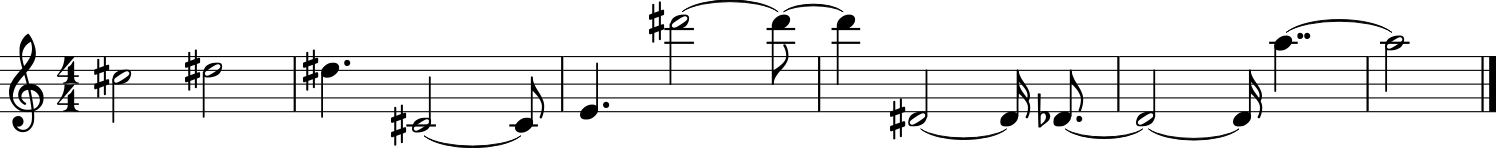

In [26]:
music = generateRandomMusic(20)

numpyArrToMidi(np.array(music[2:]), "test")

/home/fireredninja/anaconda3/envs/generateMusicProject/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


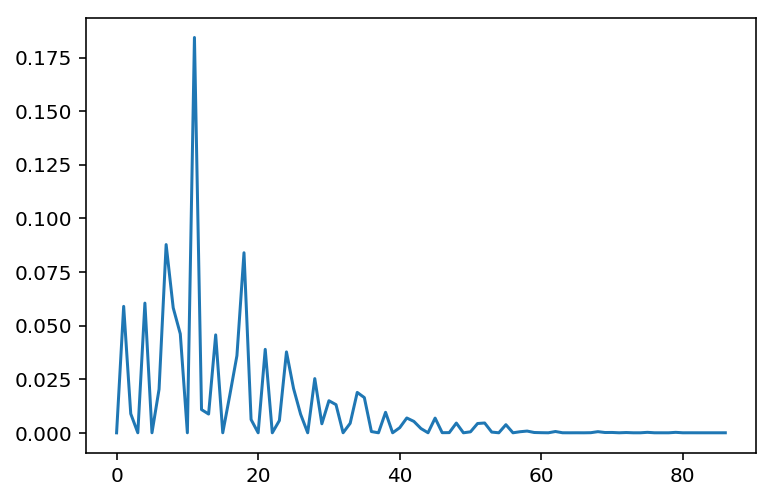

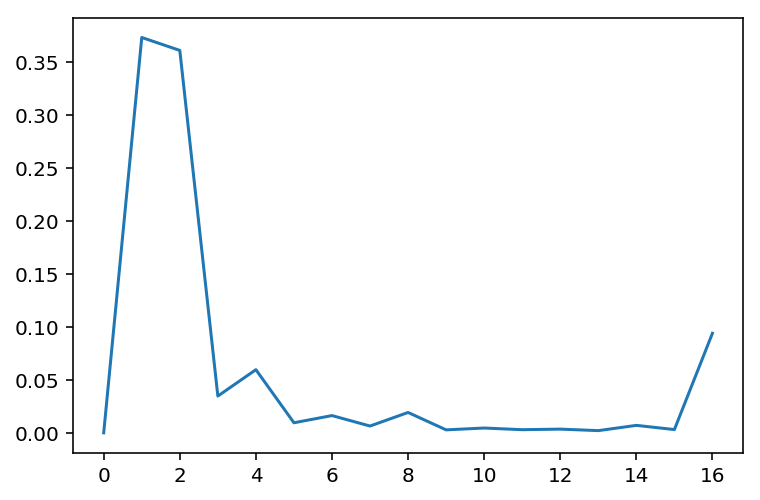

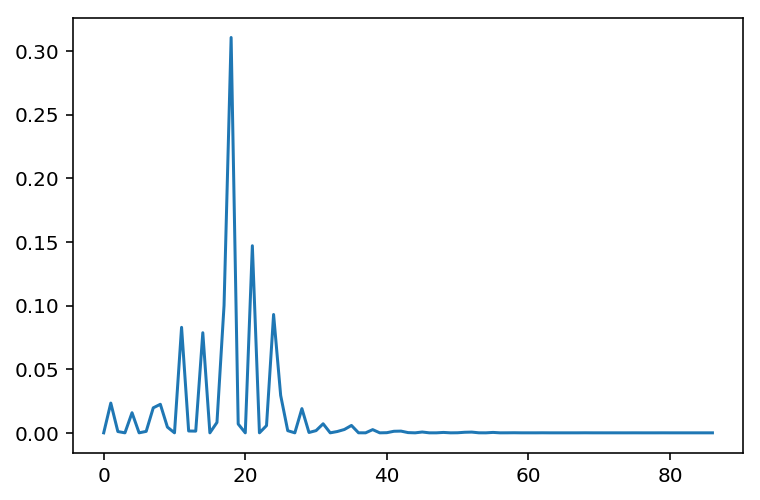

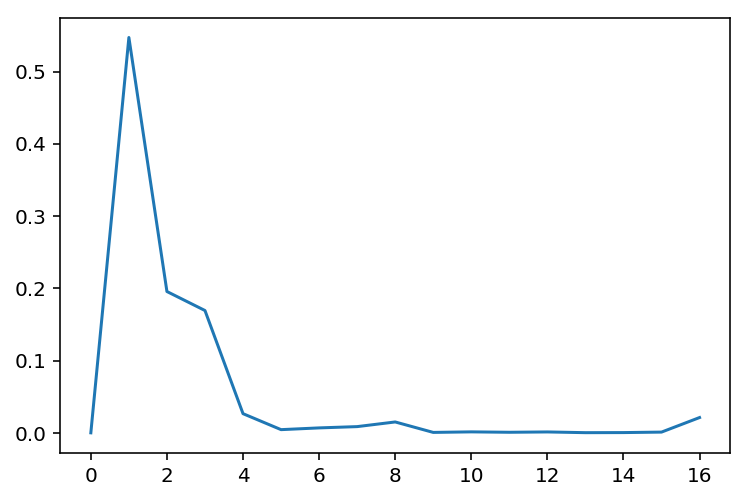

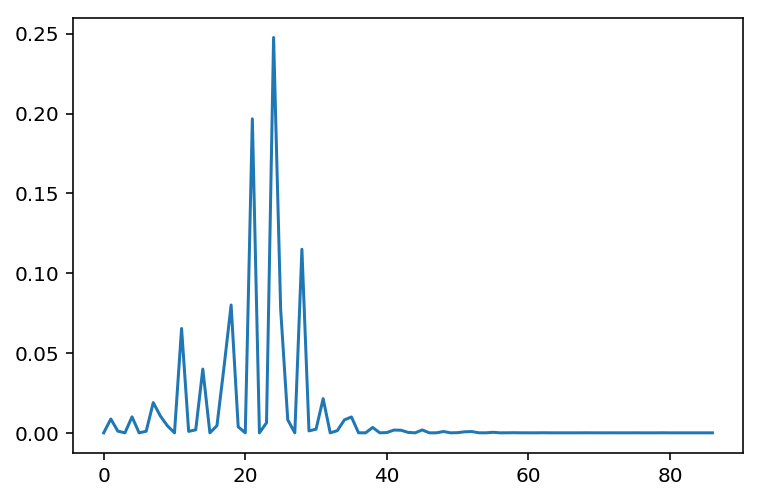

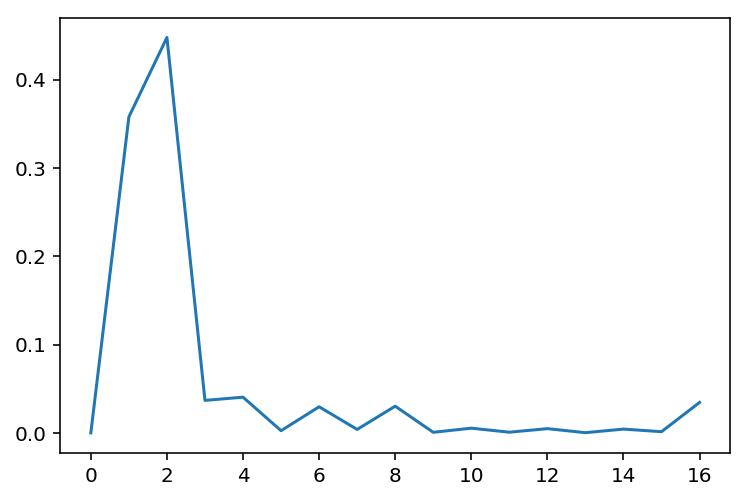

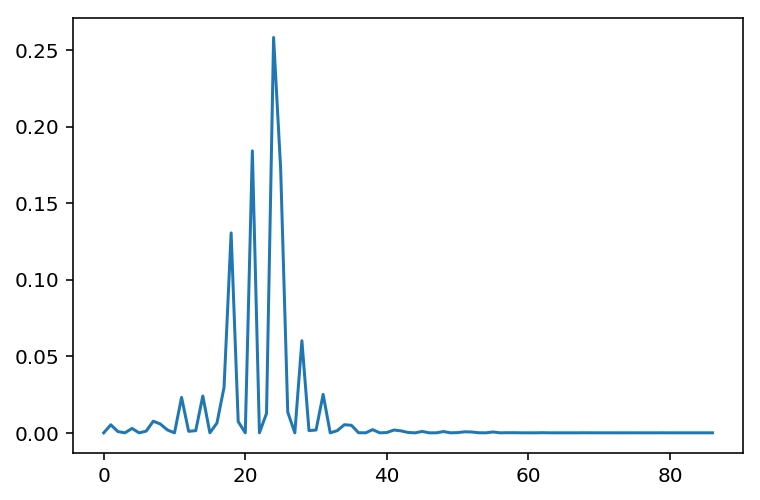

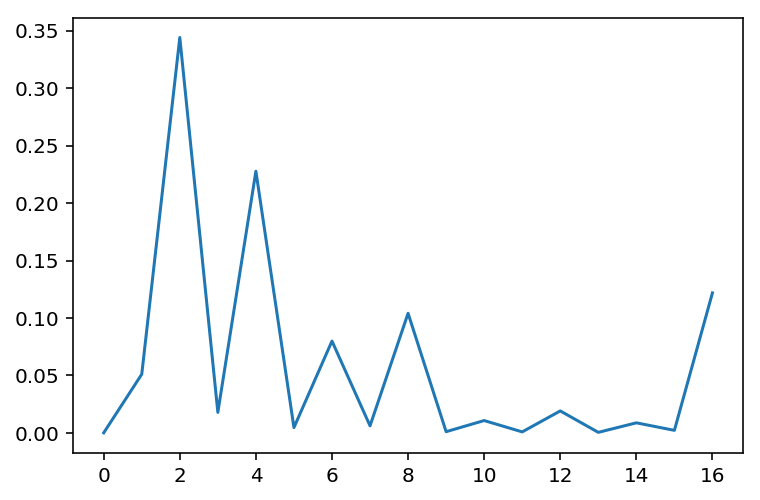

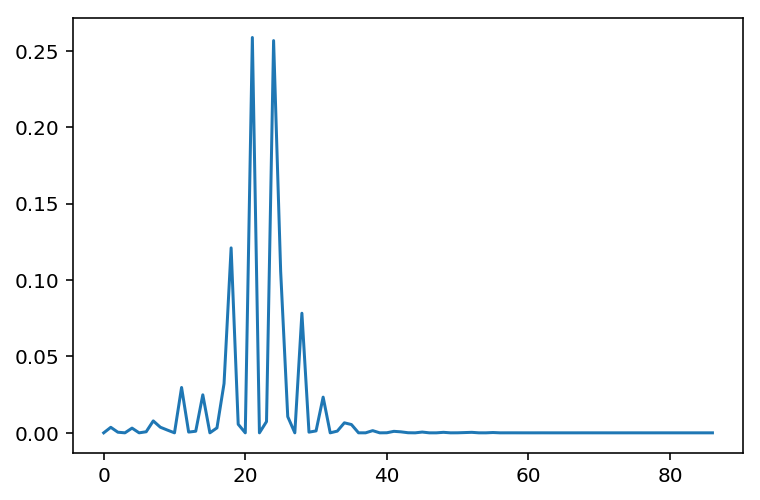

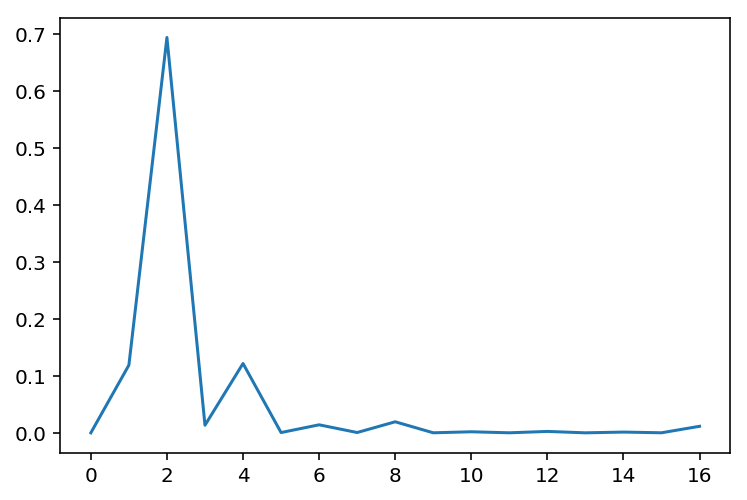

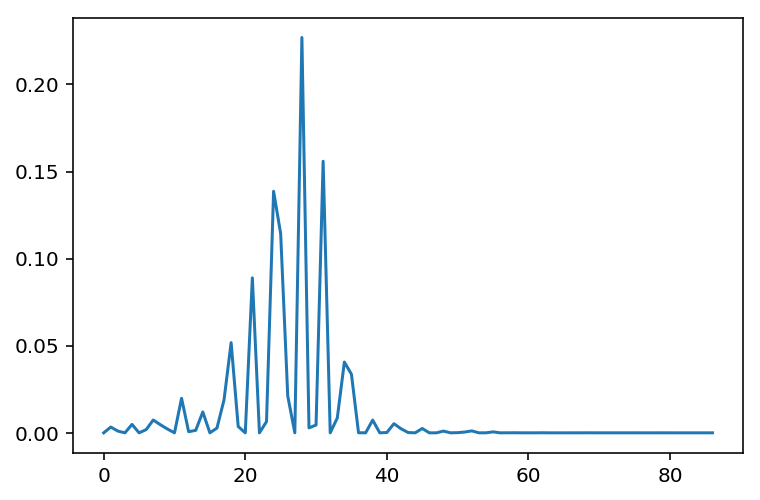

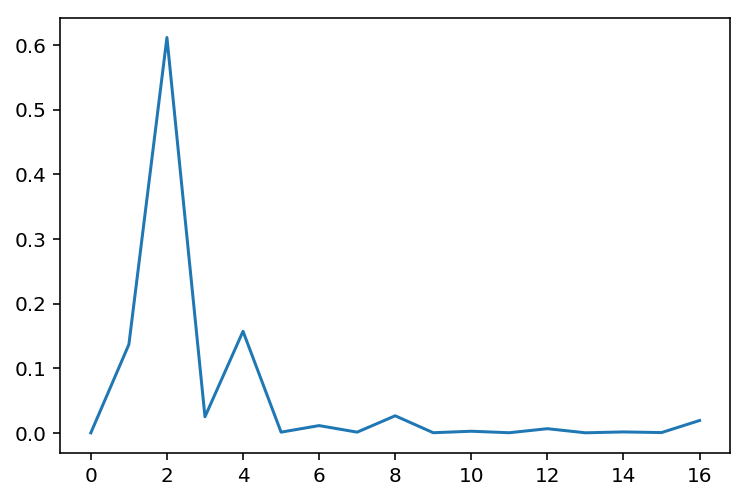

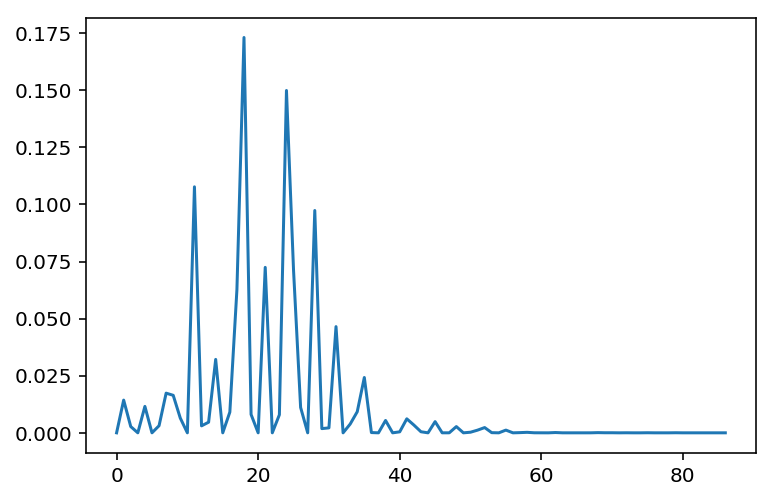

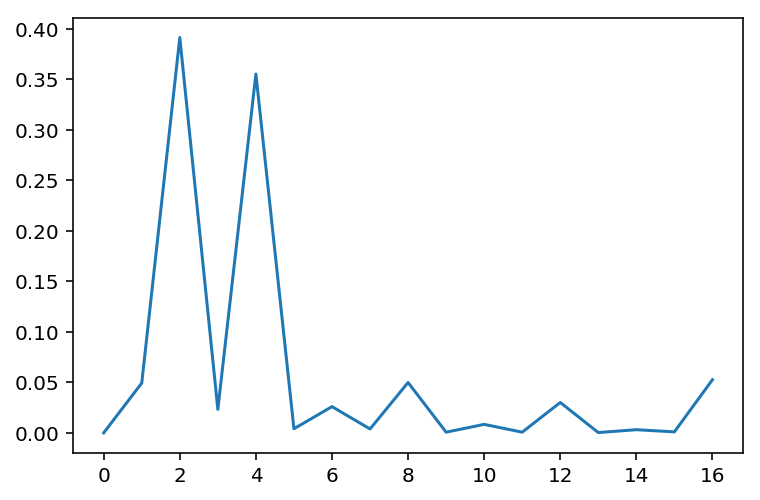

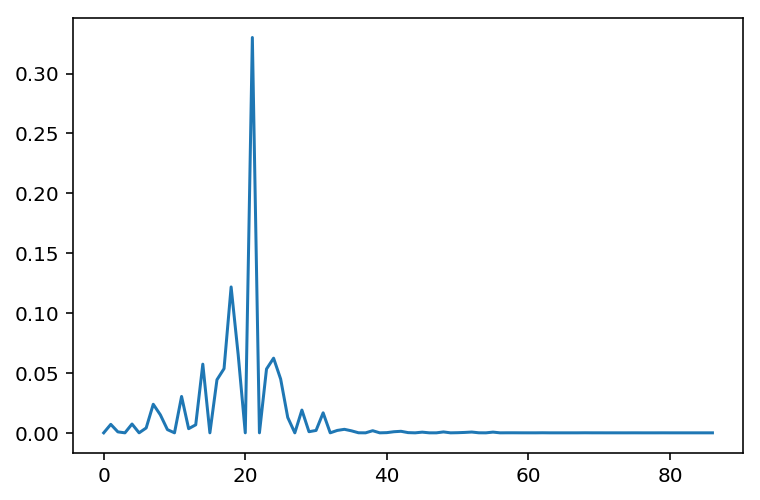

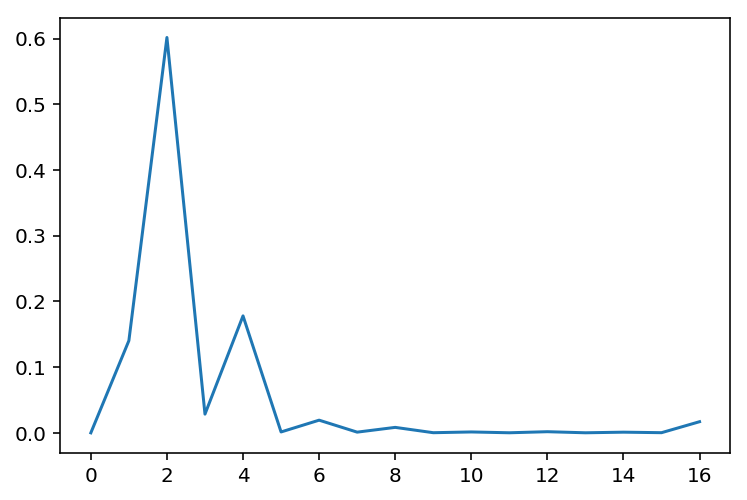

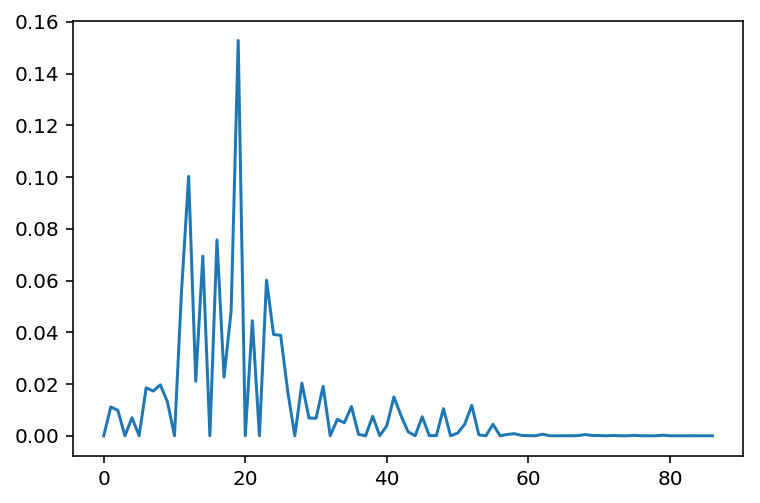

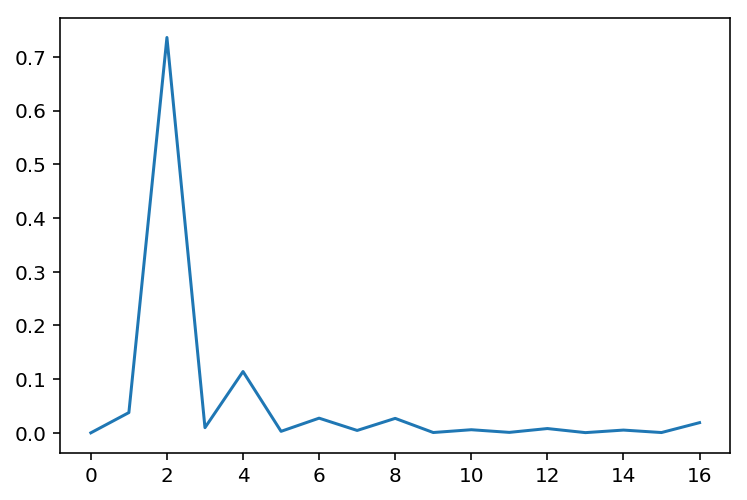

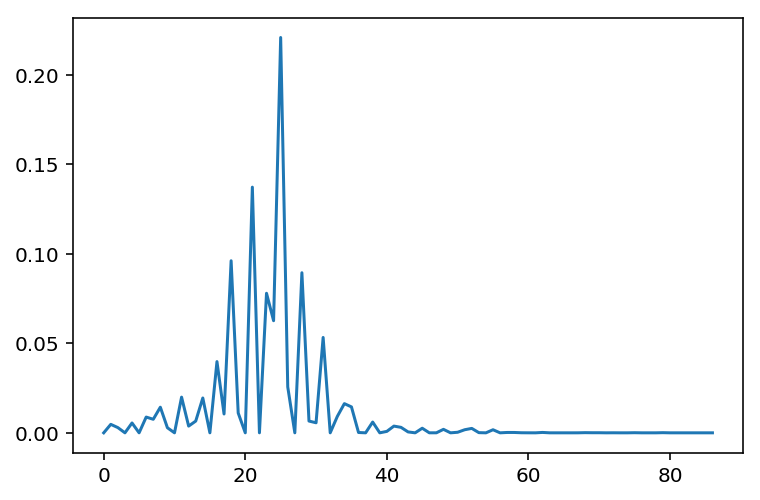

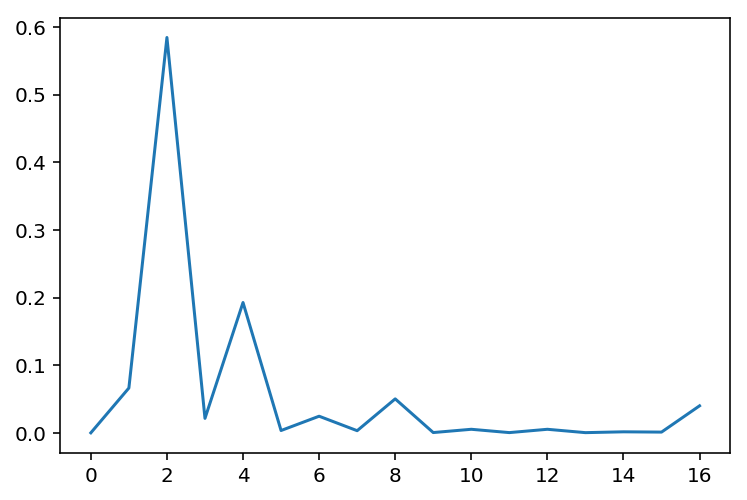

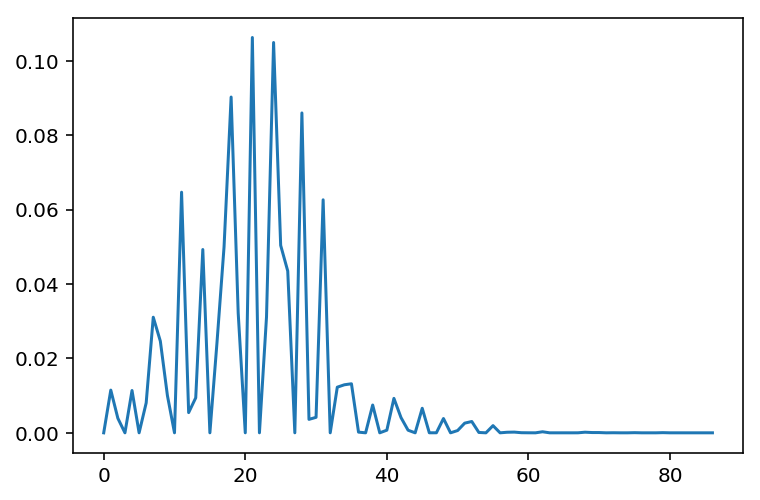

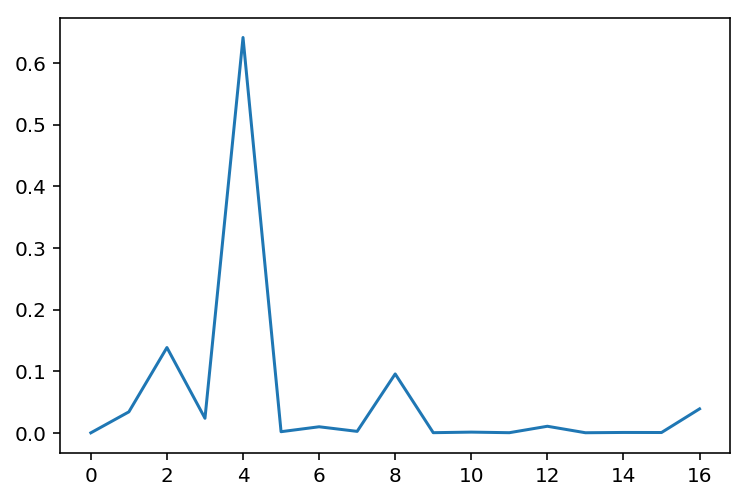

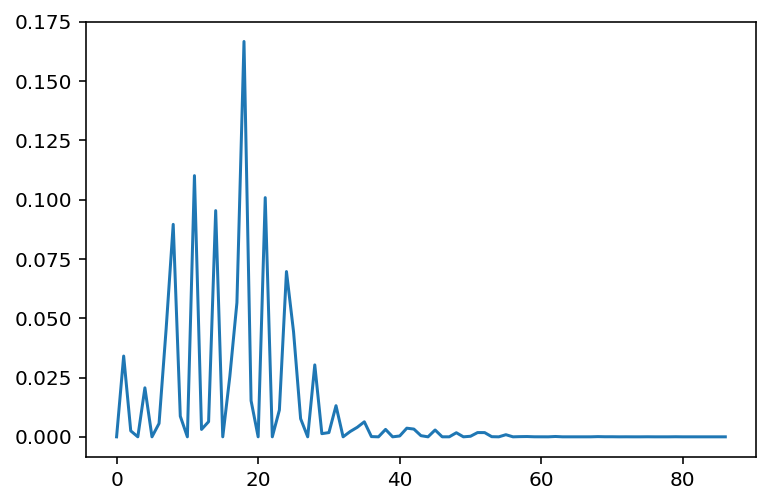

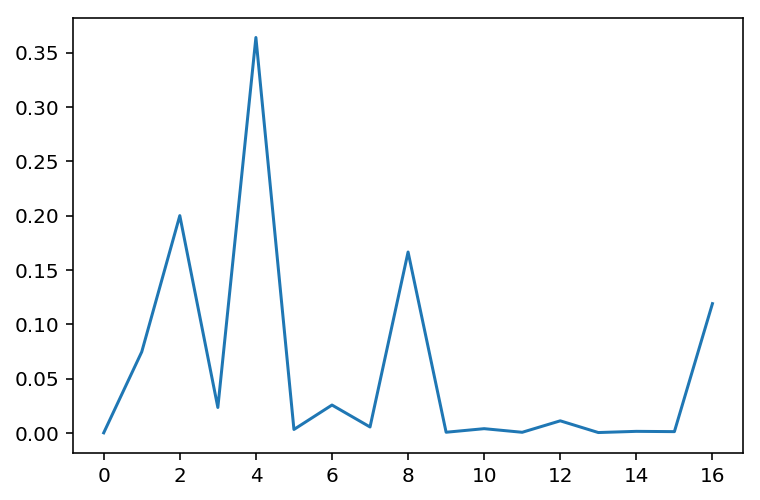

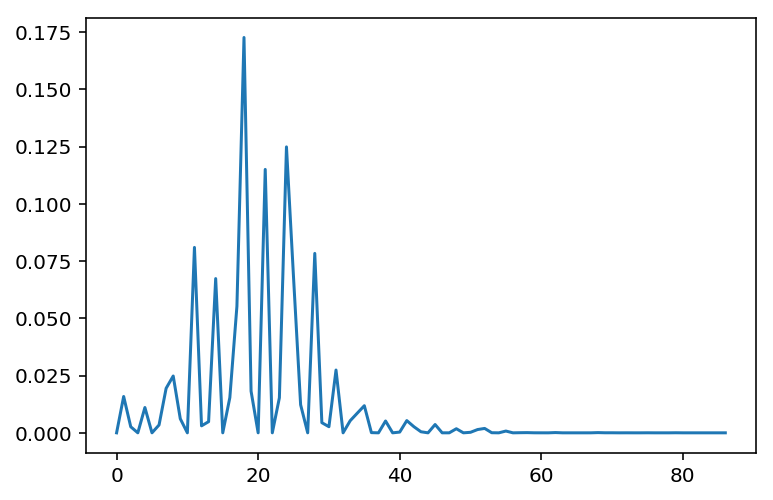

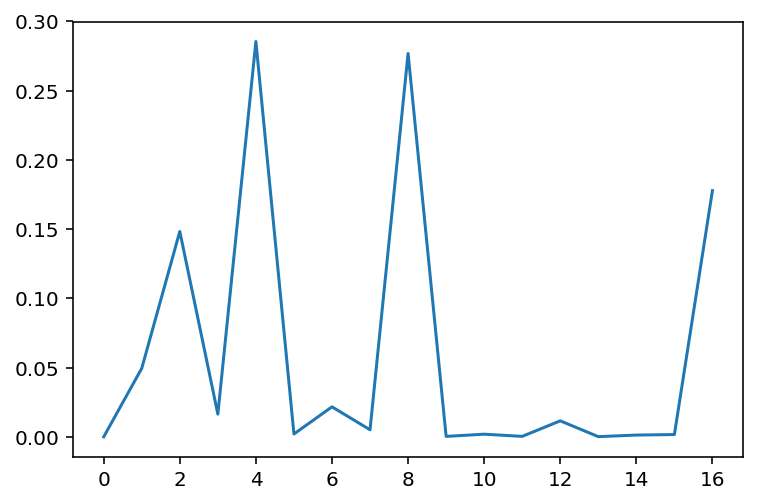

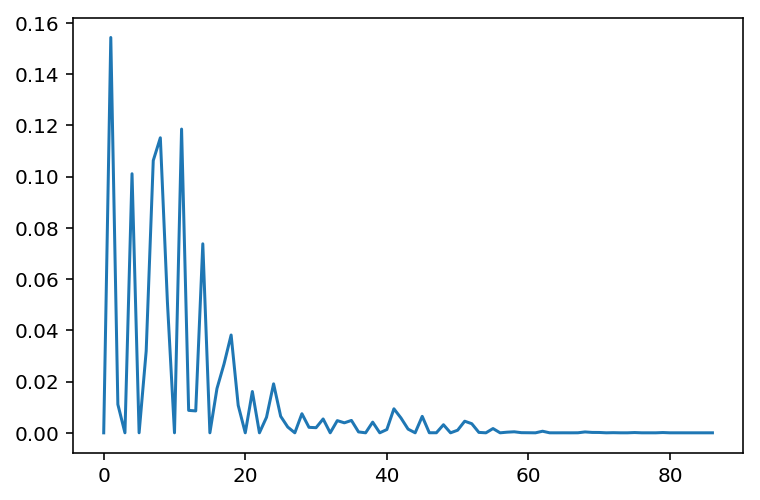

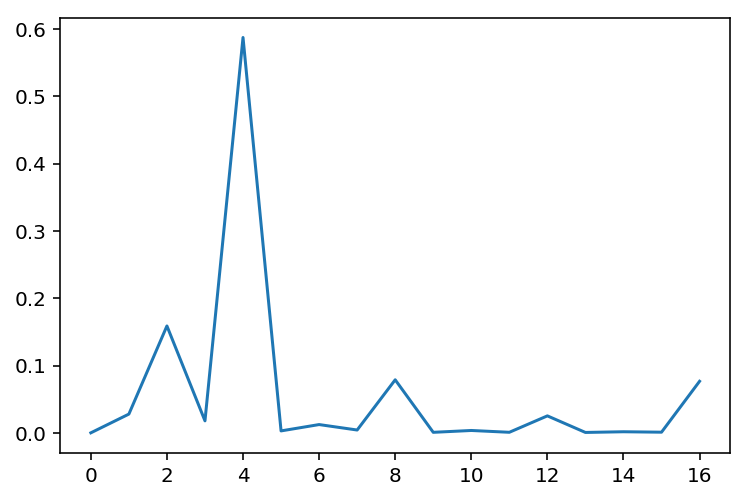

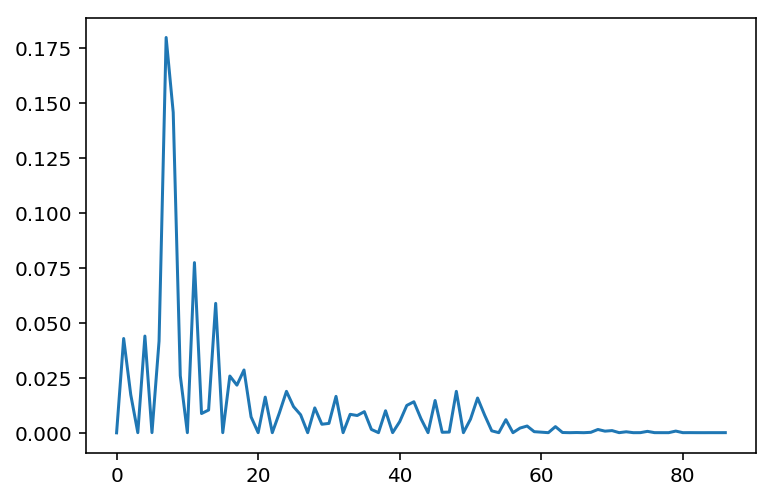

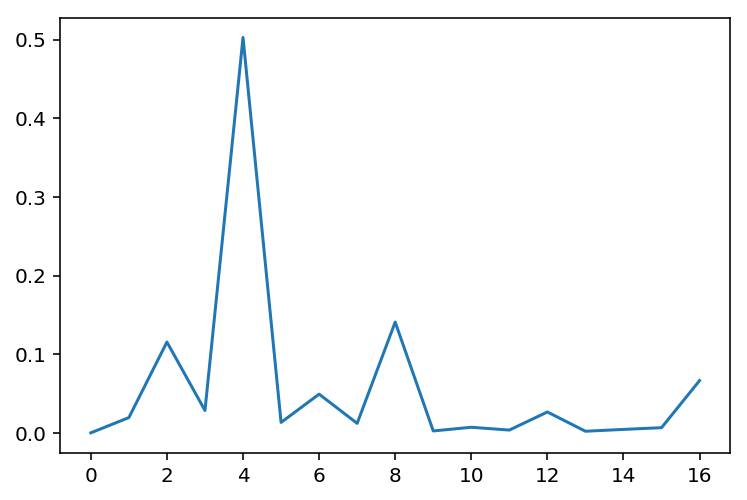

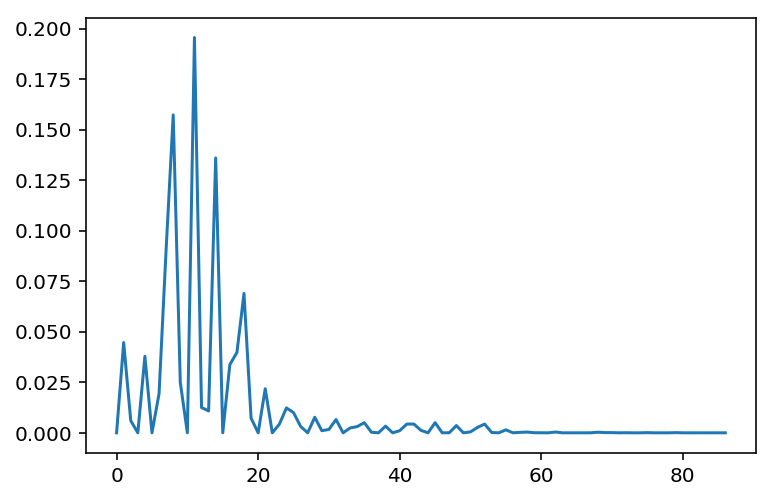

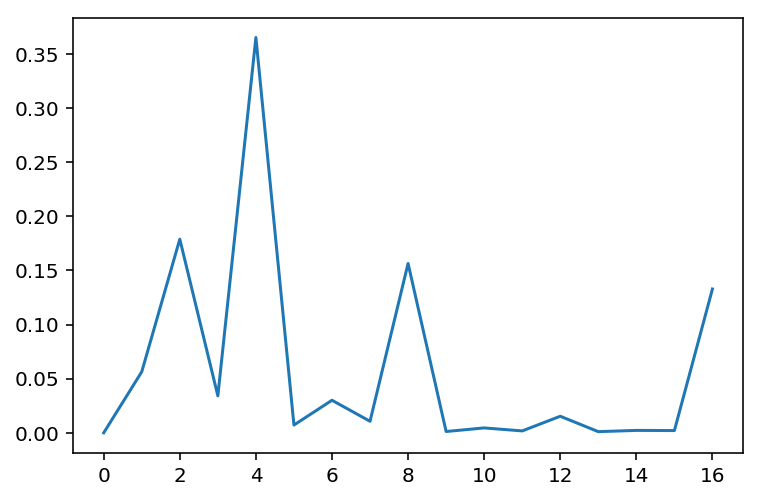

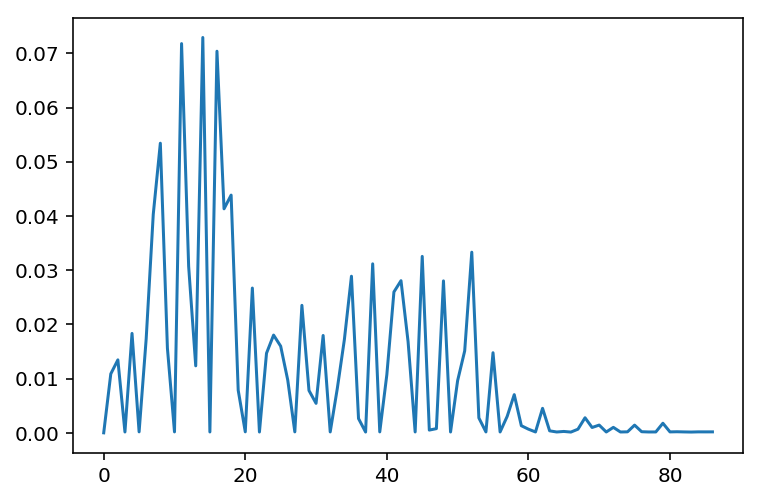

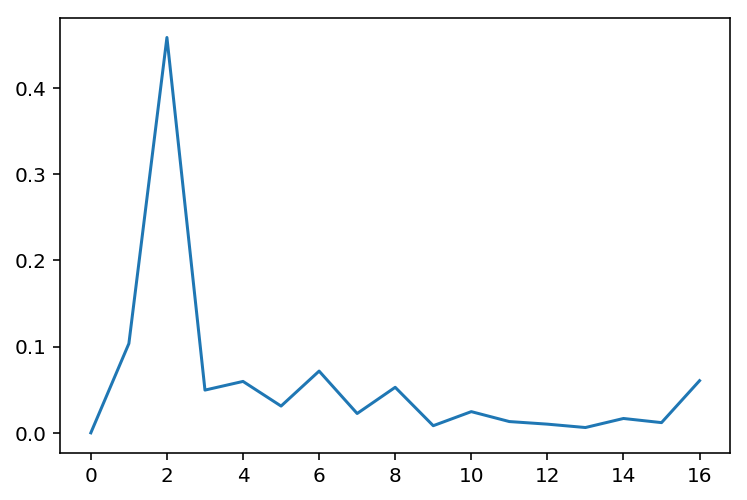

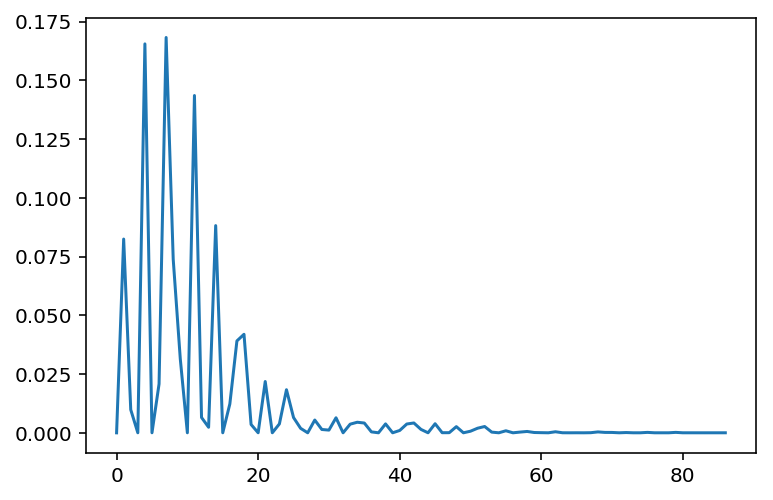

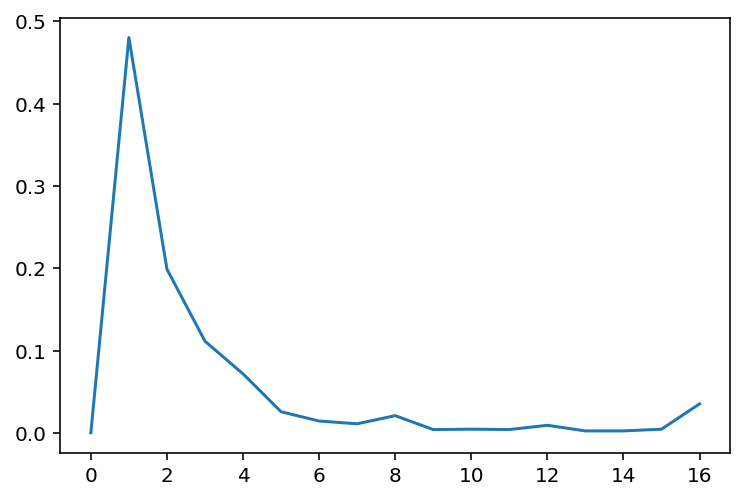

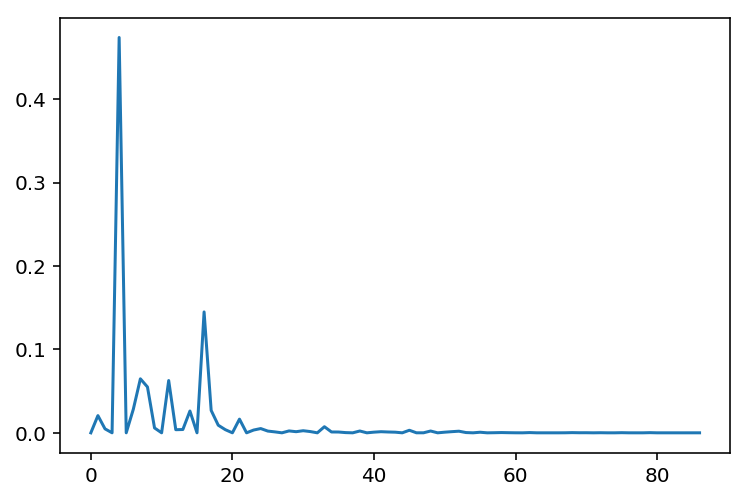

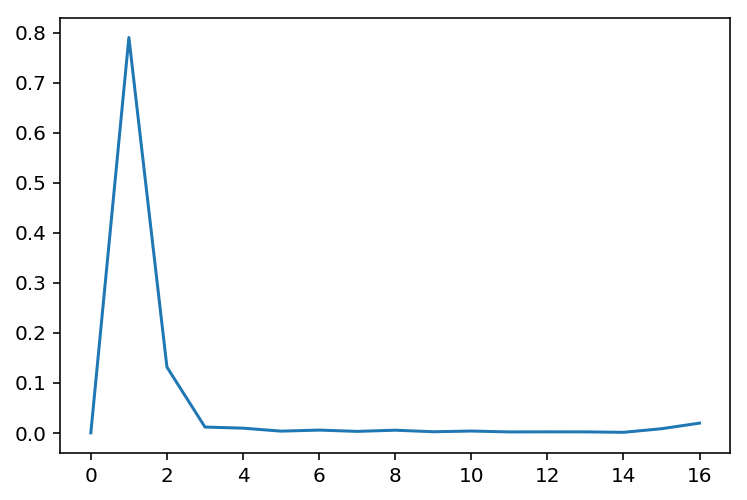

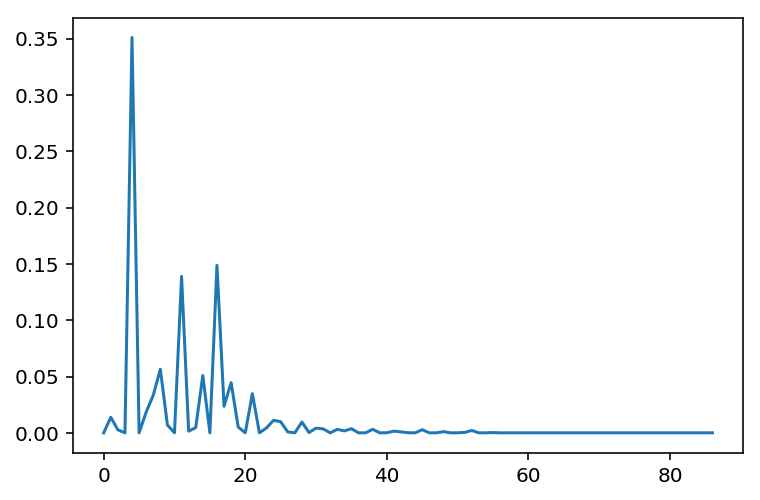

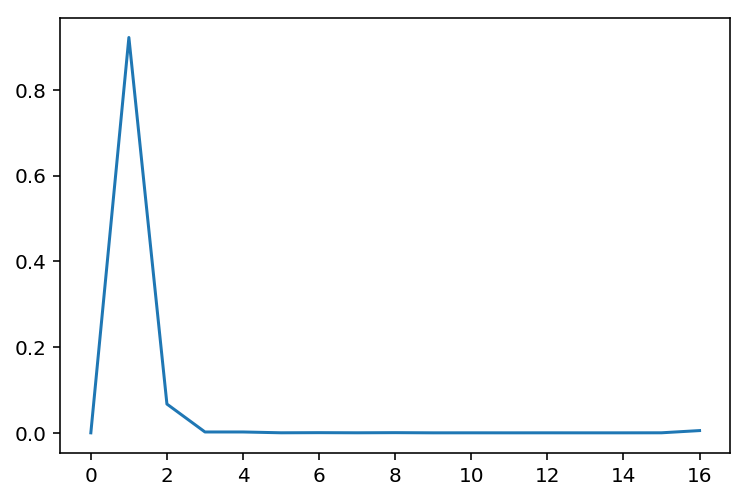

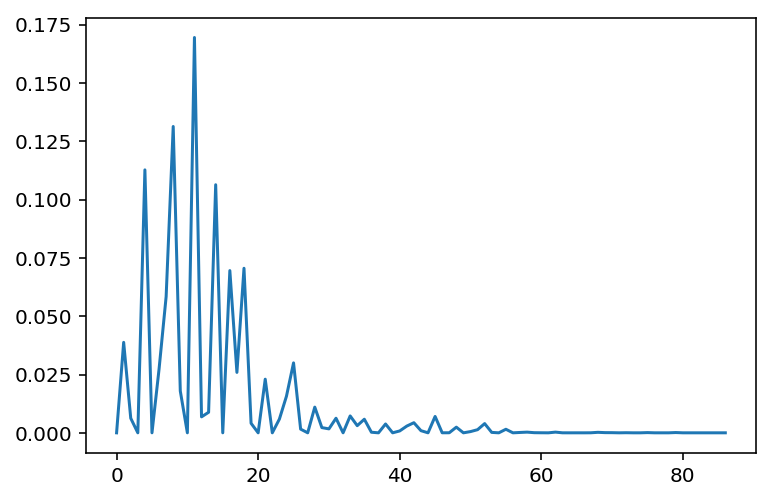

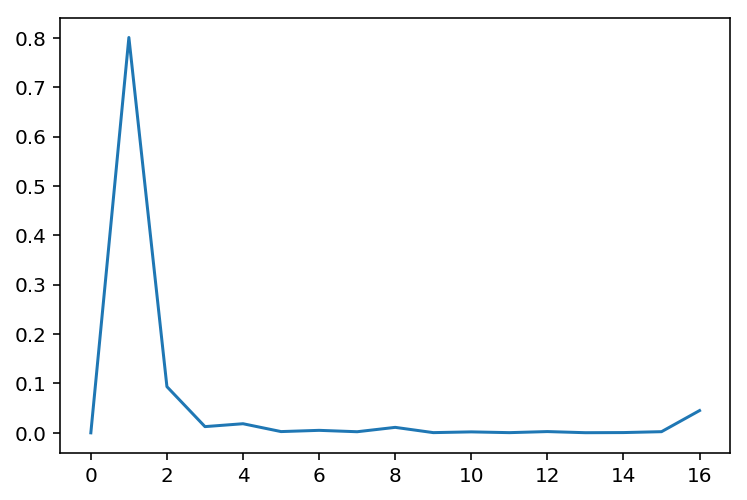

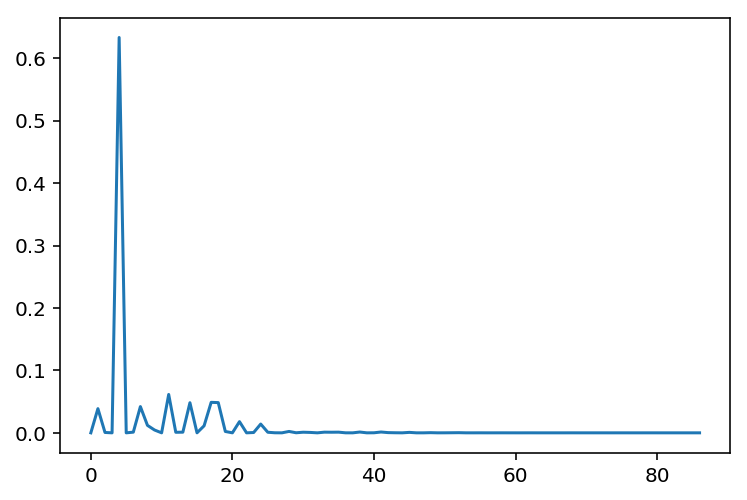

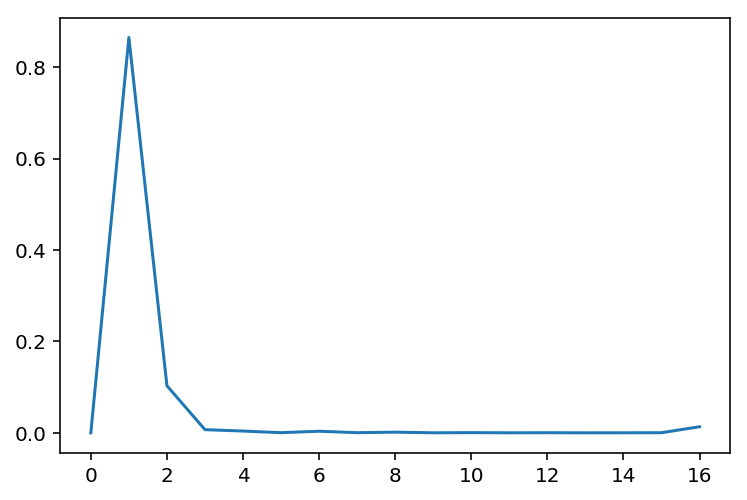

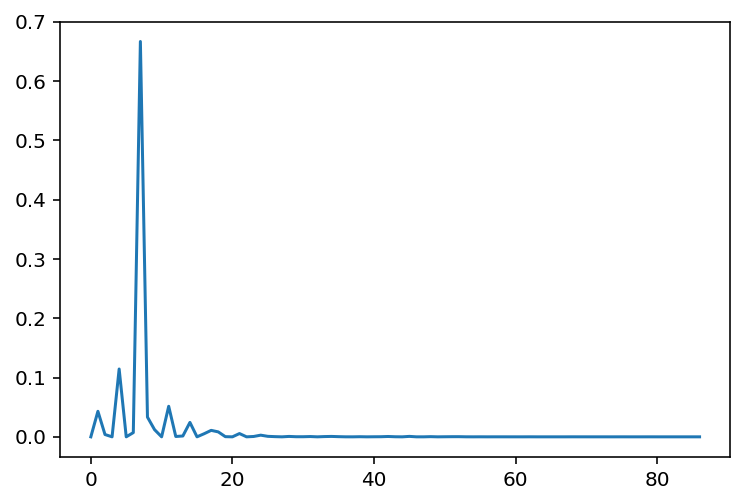

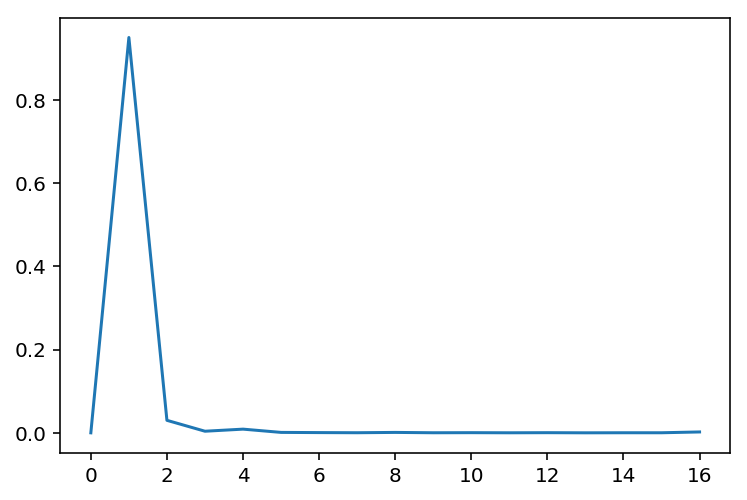

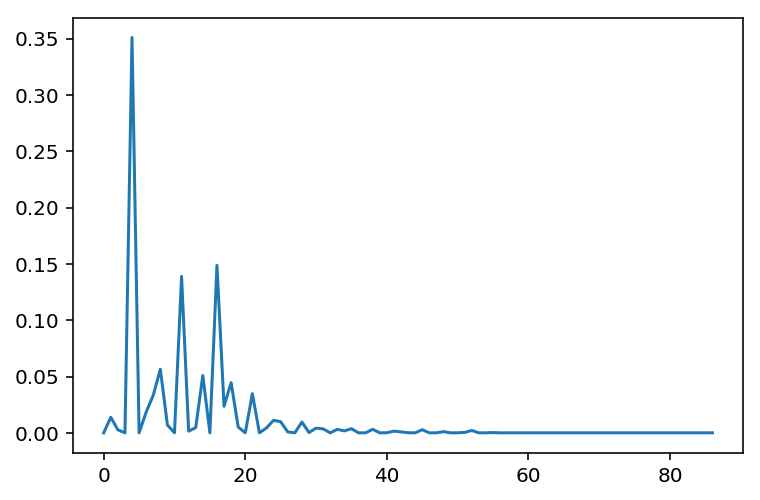

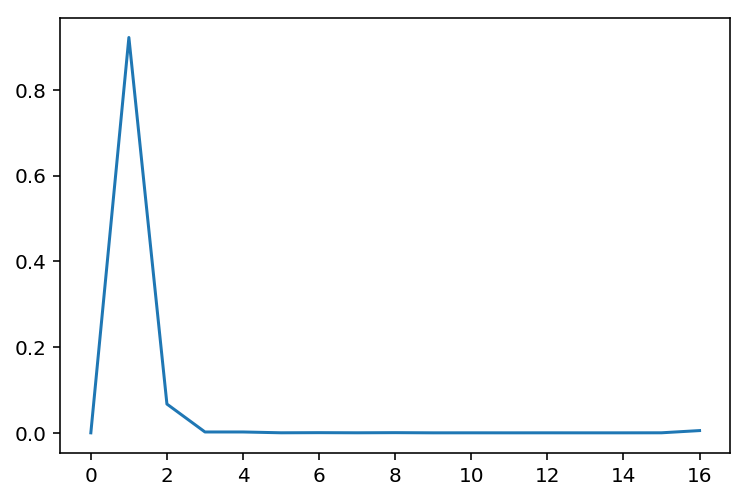

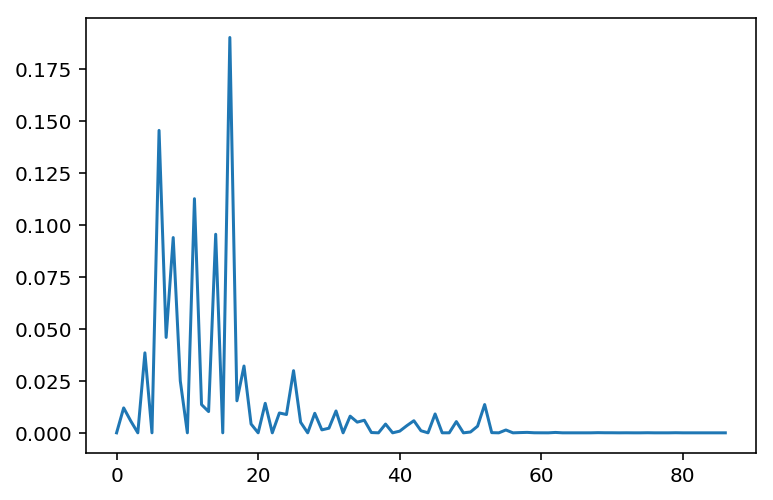

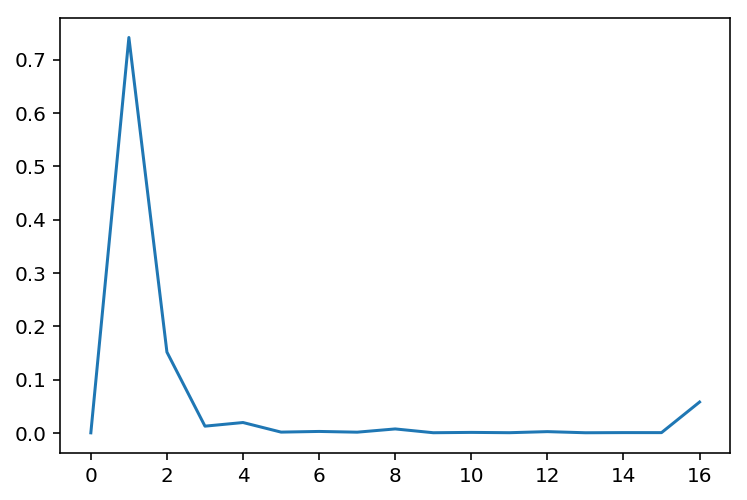

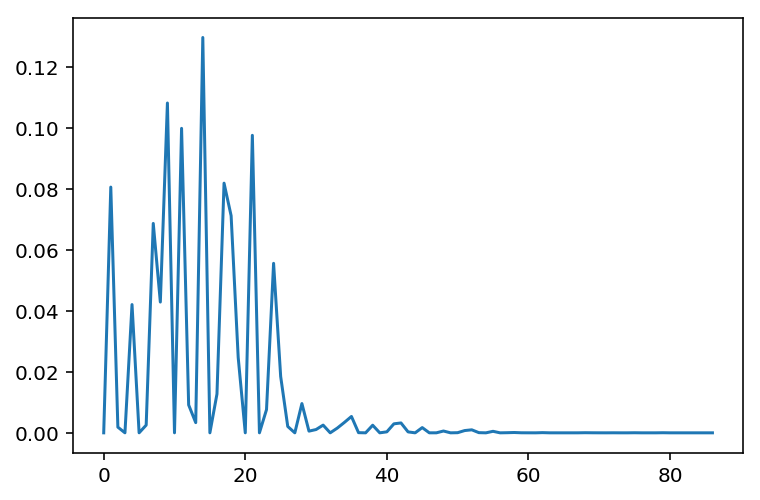

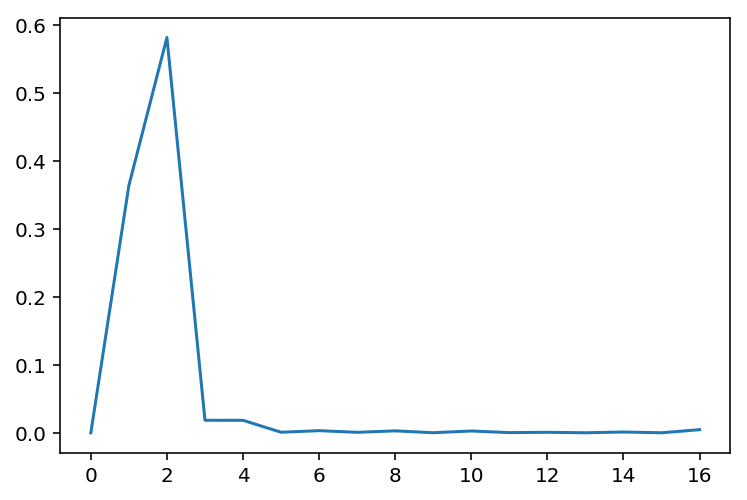

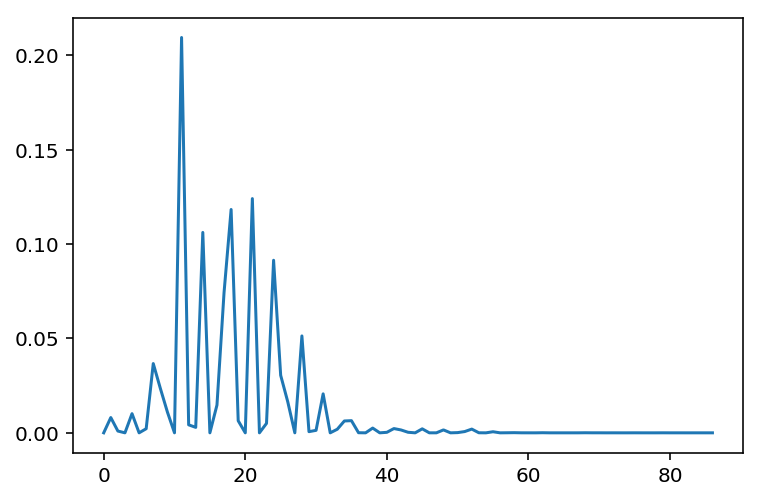

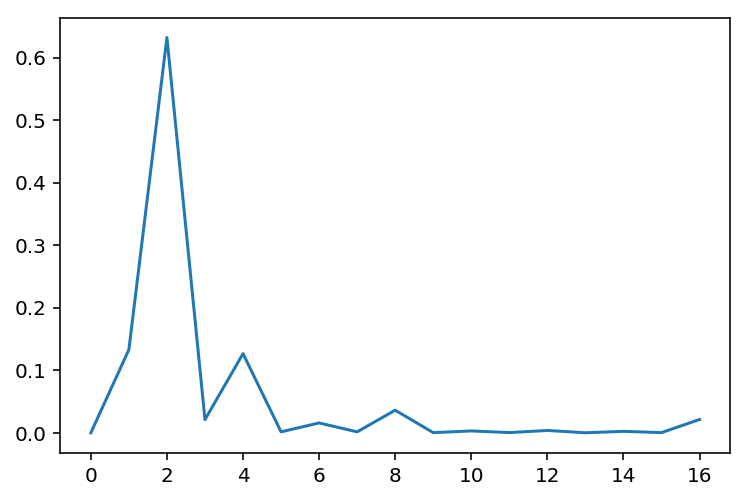

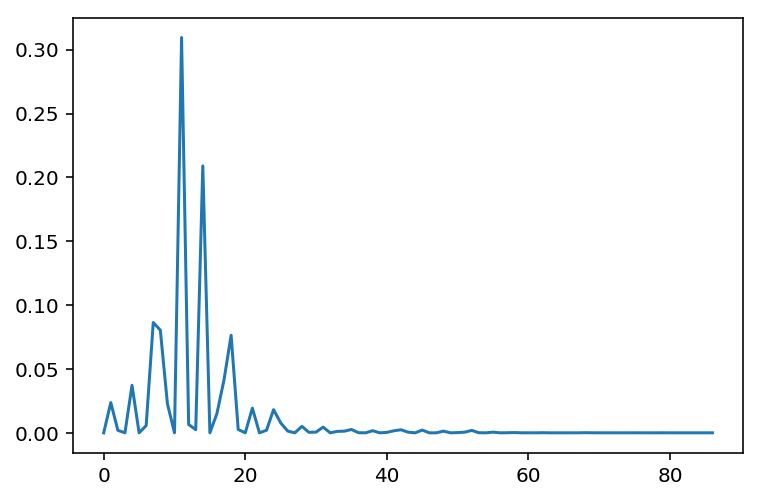

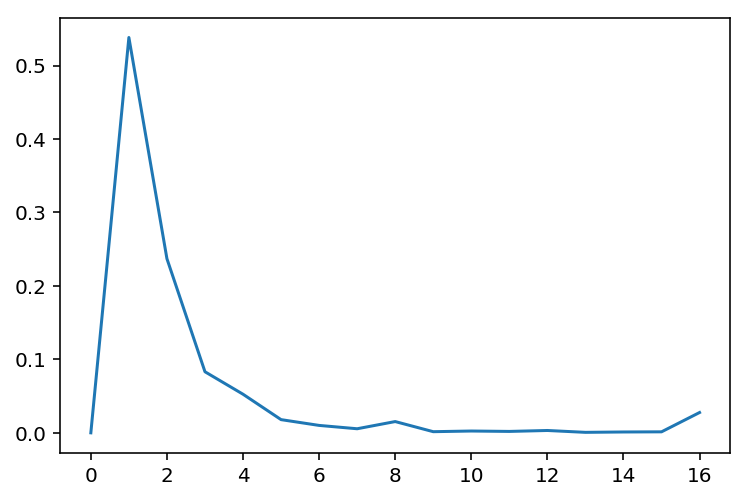

In [29]:
music = generateMusic(20)

# numpyArrToMidi(np.array(music[2:]), f"../../data/evaluation/8-bars/generated/10")

/home/fireredninja/anaconda3/envs/generateMusicProject/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


 ✔️ ../../data/evaluation/8-bars/generated/1.mid was written


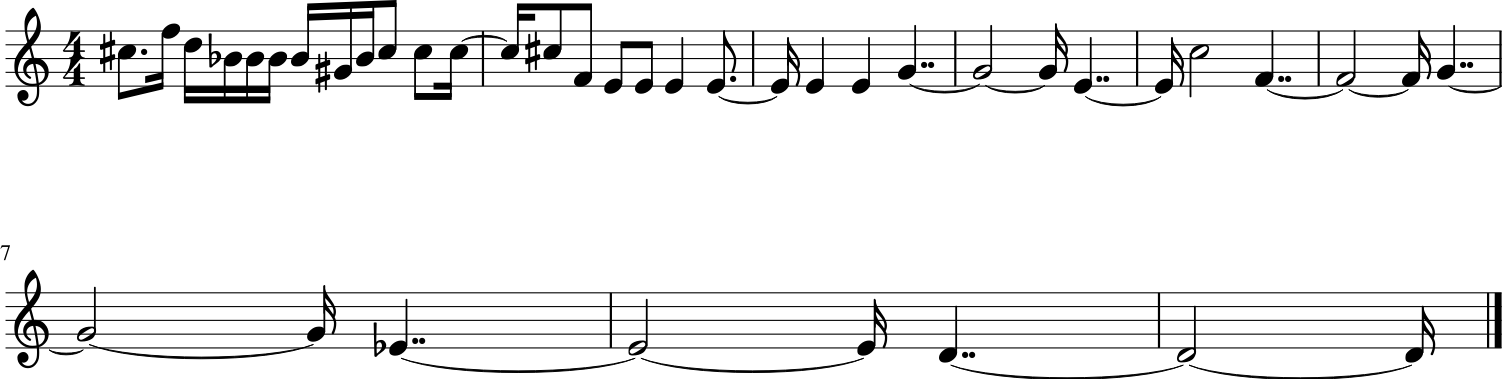

 ✔️ ../../data/evaluation/8-bars/generated/2.mid was written


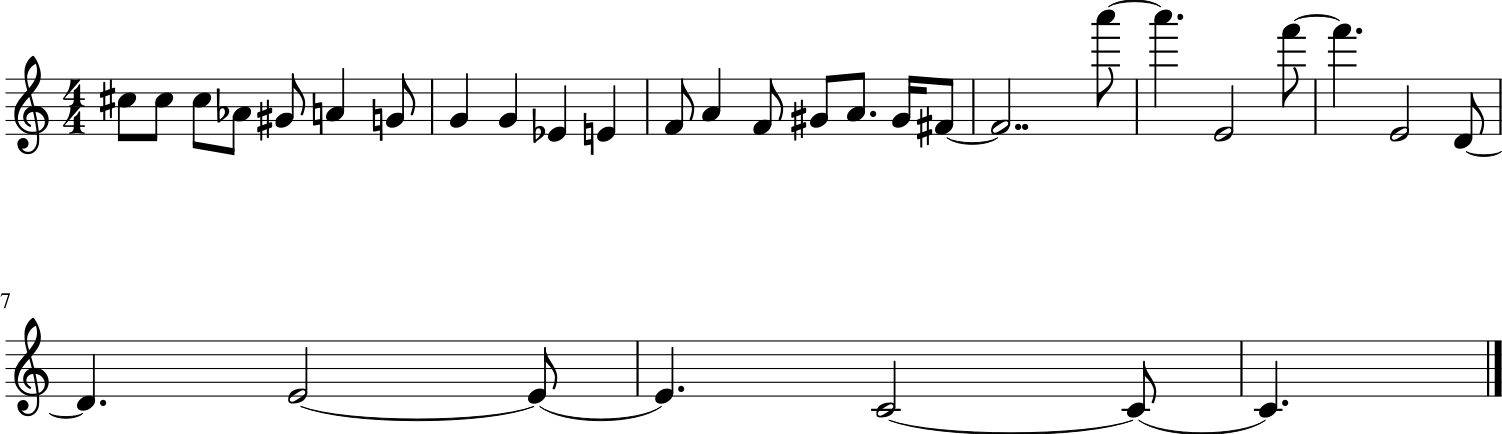

 ✔️ ../../data/evaluation/8-bars/generated/3.mid was written


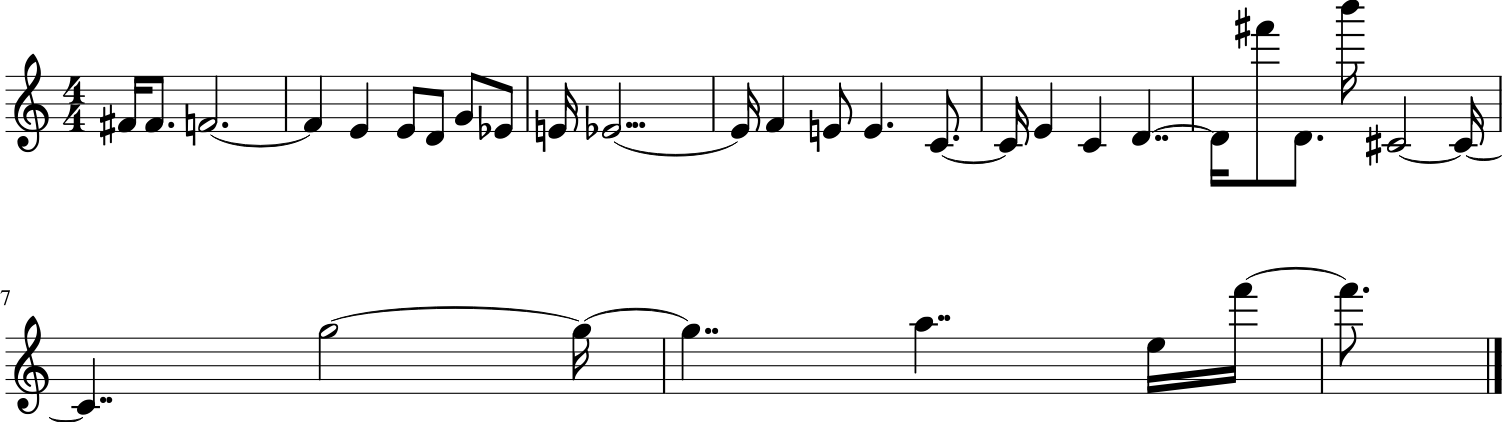

 ✔️ ../../data/evaluation/8-bars/generated/4.mid was written


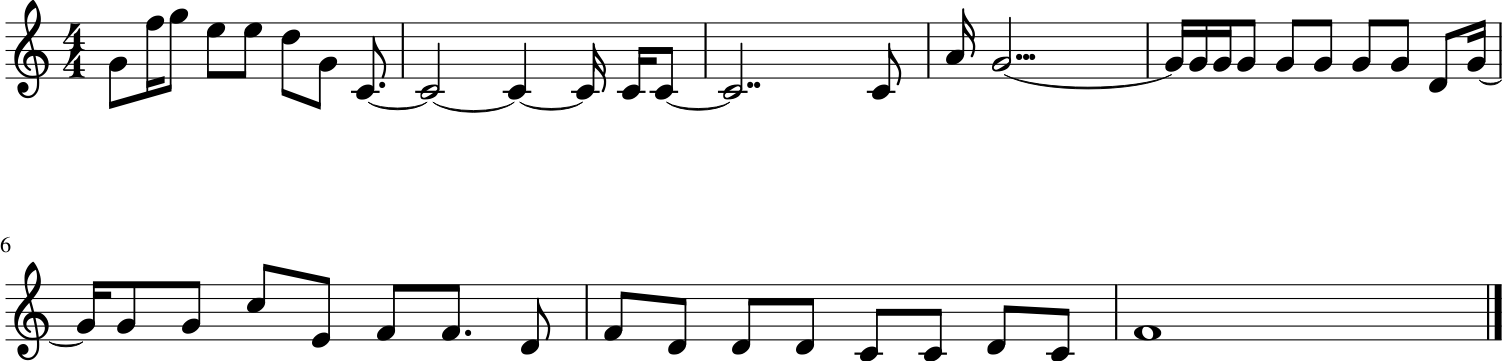

 ✔️ ../../data/evaluation/8-bars/generated/5.mid was written


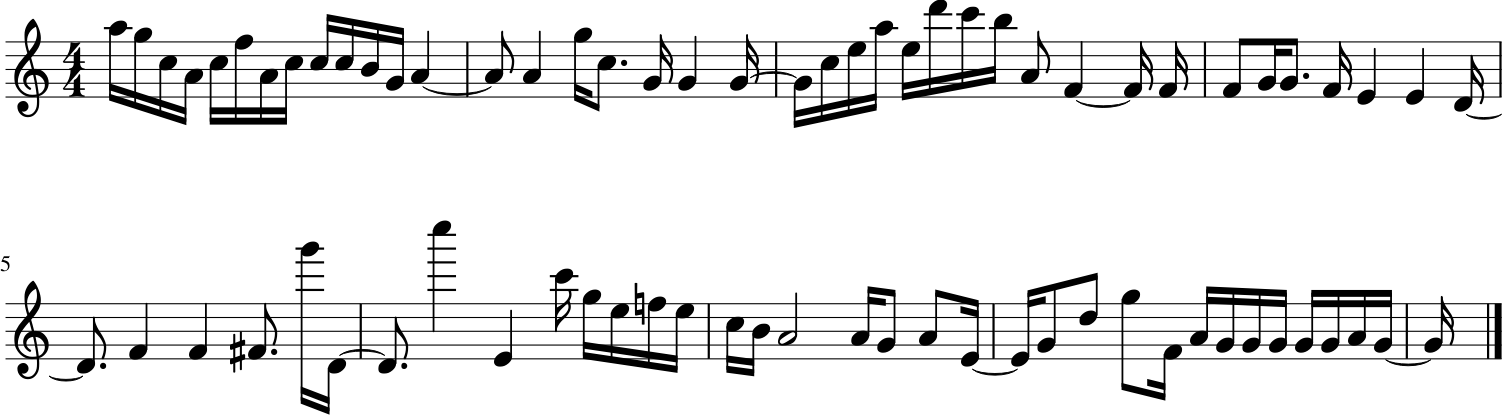

 ✔️ ../../data/evaluation/8-bars/generated/6.mid was written


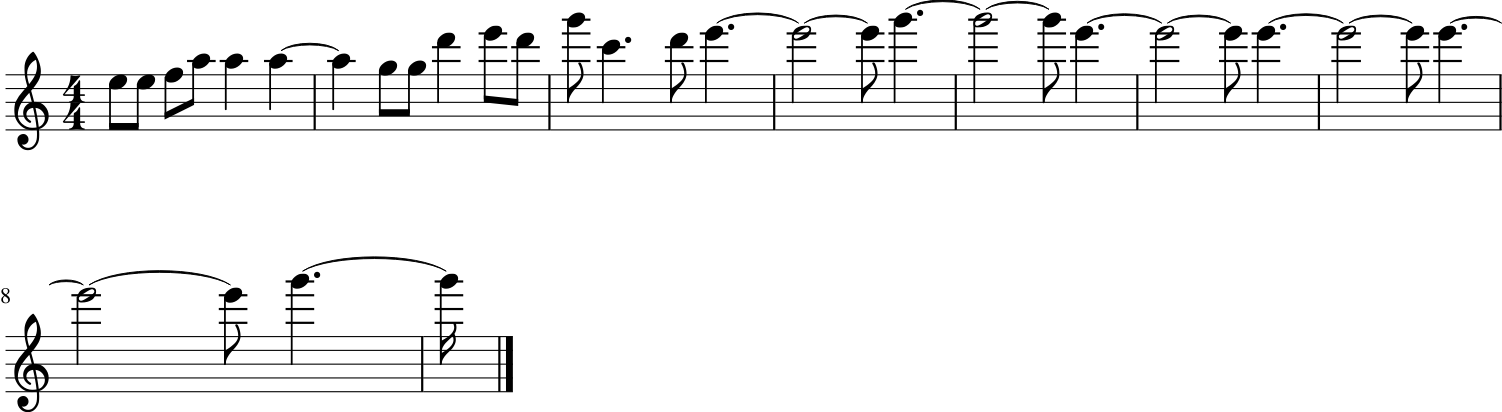

 ✔️ ../../data/evaluation/8-bars/generated/7.mid was written


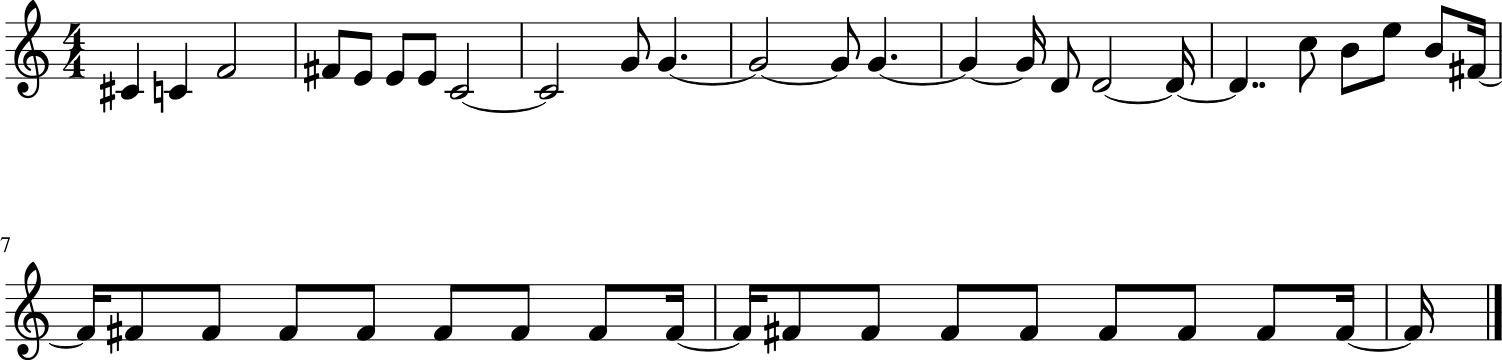

 ✔️ ../../data/evaluation/8-bars/generated/8.mid was written


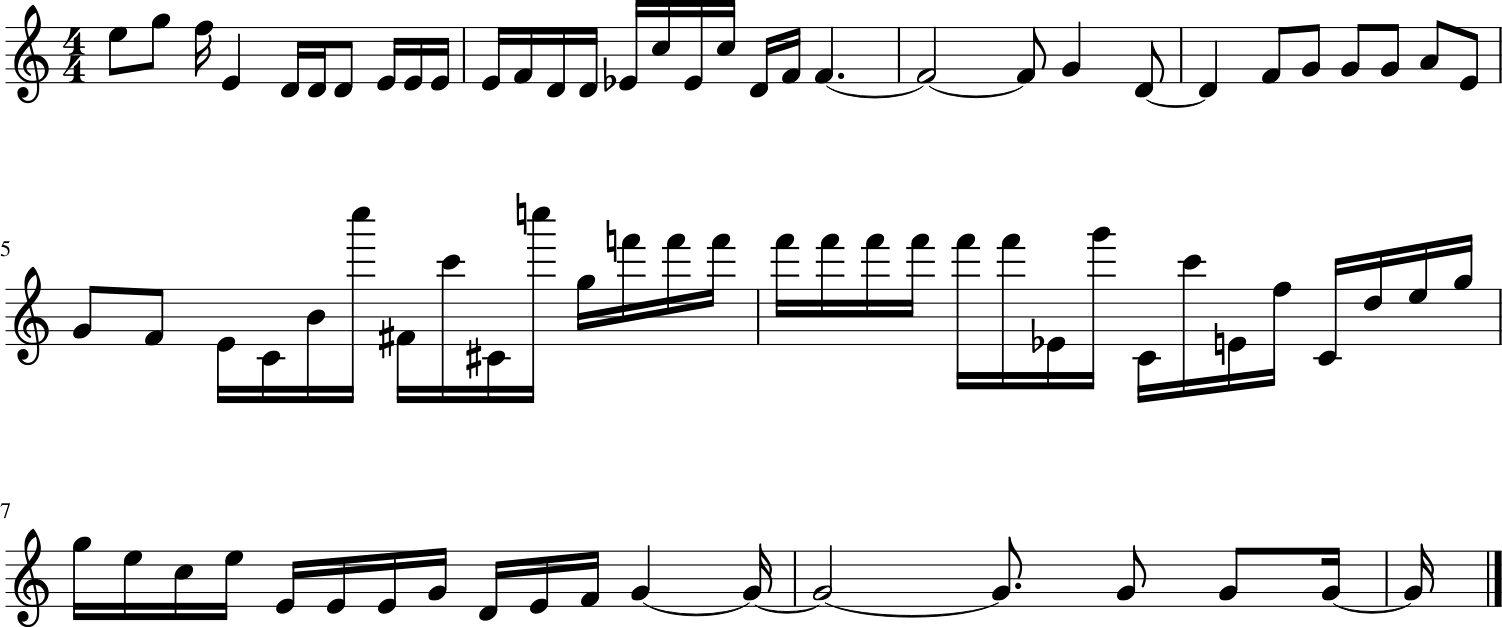

 ✔️ ../../data/evaluation/8-bars/generated/9.mid was written


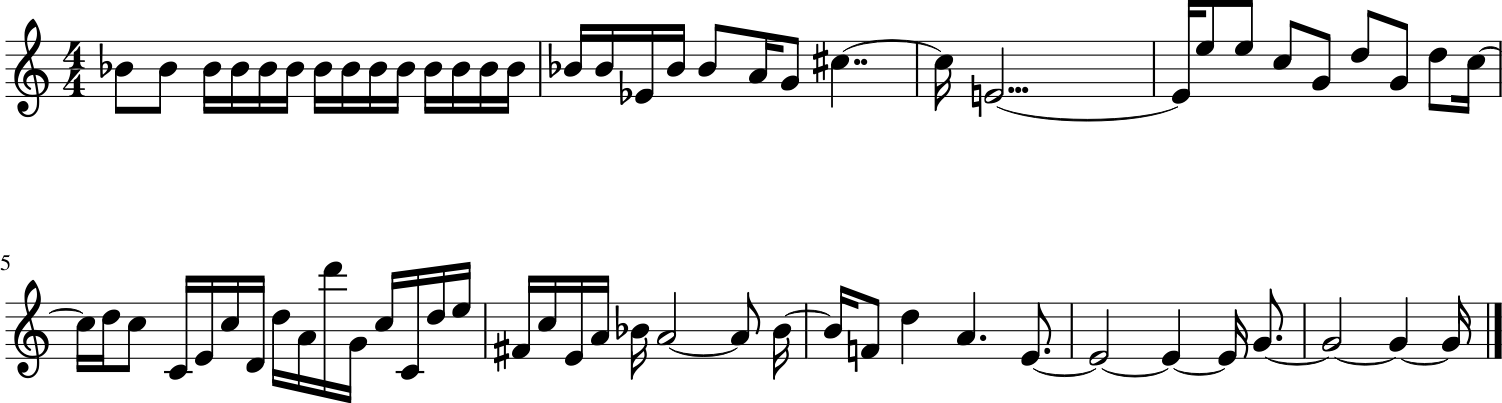

 ✔️ ../../data/evaluation/8-bars/generated/10.mid was written


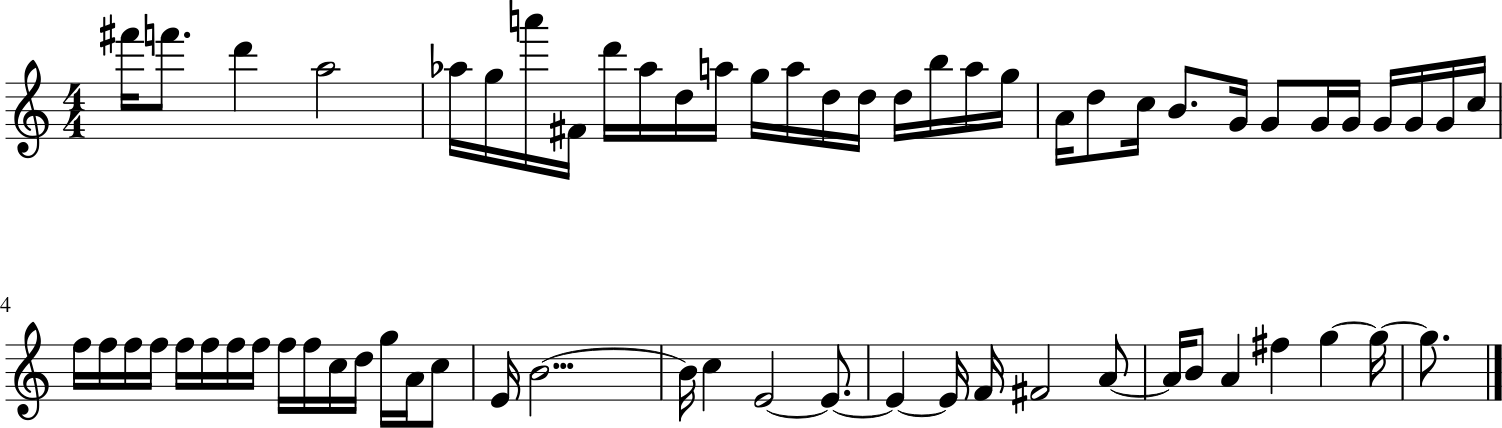

In [13]:
for i in range(1, 11):
    music = generateMusic(4*8)
    numpyArrToMidi(np.array(music[2:]), f"../../data/evaluation/8-bars/generated/{i}")

In [68]:
songs = []
for file in glob.glob("../../data/processed-130000/*.npy"):
    songs.append(file)

In [80]:
songs[np.random.randint(0, len(songs))]

'../../data/processed-130000/itsaheartache0.npy'

In [93]:
order = []
for i in range(3):
    stage = []
    for j in range(10):
        arr = np.arange(1,4)
        np.random.shuffle(arr)
        stage.append(arr)
    order.append(stage)

In [94]:
print(np.array(order))

[[[3 1 2]
  [1 2 3]
  [3 1 2]
  [2 3 1]
  [1 2 3]
  [3 2 1]
  [3 1 2]
  [2 3 1]
  [1 2 3]
  [1 2 3]]

 [[1 3 2]
  [1 2 3]
  [1 2 3]
  [1 2 3]
  [1 2 3]
  [2 3 1]
  [1 2 3]
  [1 3 2]
  [3 2 1]
  [3 1 2]]

 [[1 3 2]
  [3 1 2]
  [2 1 3]
  [2 1 3]
  [2 3 1]
  [1 2 3]
  [1 3 2]
  [3 2 1]
  [2 1 3]
  [2 3 1]]]


In [ ]:
[[[3 1 2]
  [1 2 3]
  [3 1 2]
  [2 3 1]
  [1 2 3]
  [3 2 1]
  [3 1 2]
  [2 3 1]
  [1 2 3]
  [1 2 3]]

 [[1 3 2]
  [1 2 3]
  [1 2 3]
  [1 2 3]
  [1 2 3]
  [2 3 1]
  [1 2 3]
  [1 3 2]
  [3 2 1]
  [3 1 2]]

 [[1 3 2]
  [3 1 2]
  [2 1 3]
  [2 1 3]
  [2 3 1]
  [1 2 3]
  [1 3 2]
  [3 2 1]
  [2 1 3]
  [2 3 1]]]